# Business Understanding 

CMS rates hospitals in the US on a scale of 1-5 with the objective to make it easier for patients and consumers to compare the quality of hospitals.
The ratings directly influence the choice of the hospital made by consumers and may have a significant impact on the revenue earned by hospitals.
Thus, it is extremely important for hospitals to understand the methodology used by CMS for calculating the ratings so that they can work on
improving the factors that influence them.
 
This project is focused on developing an approach to calculate hospital ratings and using it to identify areas of improvement for
certain hospitals. It will also require a thorough understanding of the rating system developed by CMS.


# Business Problem 

The aim of analysis is to understand the methodology used by CMS for calculating the ratings and identify
the factors influencing the ratings for hospitals, so that they can work on improving the factors that influence them.
Recommend ways to improve the rating for Evanston Hospital to improve their current star rating of 3/5*



# Data Understanding #

The original source of data is `Hospital_Revised_FlatFiles_20161110`
  CSV Files
1.	Readmissions and Deaths - Hospital.csv	                                                readmission.csv
2.	Readmissions and Deaths - Hospital.csv +   Complications - Hospital.csv	                mortality.csv
3.	Healthcare Associated Infections - Hospital.csv +   Complications - Hospital.csv	      safety.csv
4.	HCAHPS - Hospital.csv	                                                                  experience.csv
5.	Outpatient Imaging Efficiency - Hopital.csv	                                            medical.csv
6.	Timely and Effective Care - Hospital.csv	                                              timeliness.csv
7.	Timely and Effective Care - Hospital.csv	                                              effectiveness.csv


# Exploratory Data Analysis 

- Perform the Univariate analysis for all the groups.
- Perform Bi-variate analysis for all the groups.


Modelling 

 Part 1 - Supervised Learning-Based Rating
 Part 2 - Factor analysis and Clustering-Based Rating (Unsupervised)
 Part 3 - Provider analysis - Recommendations for Hospitals

Let us load the data and create the groups as above:
Copied the required raw files to the Groups location.
1. "Readmissions and Deaths - Hospital.csv"
2. "Complications - Hospital.csv"
3. "Healthcare Associated Infections - Hospital.csv"
4. "HCAHPS - Hospital.csv"
5. "Outpatient Imaging Efficiency - Hospital.csv"
6. "Timely and Effective Care - Hospital.csv"



# Data Prepartion, cleaning and Supervised Modelling 
Data set contains 58 excel files, 2 PDF files out of this for this assignment we require 6 files & it has suffix as "_Hospital"

Load the files into dataframes:
1. Load the data - replace Not Available, Not Applicable with NA  (Suffix _Raw dataframes )
2. Split xxxx_rawdata frames into 2 data frames [xxxx_hosp, xxxx_meas)
3. Rename columns - Standardize names across
4. Reorder columns to match all files
5. Standardize the measures- some measures with positive zscores and some measures with negative zscores.
6. Impute the outliers

# Libraries to be used


In [120]:
import os
os.chdir("/Users/eklavya/projects/education/formalEducation/DataScience/DataScienceAssignments/HealthCare/Capstone/submission/")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree



import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_context('paper')




# Utility functions 

In [2]:
def print_ln():
    print('-' * 80, '\n')


# Function to create a subset of the dataframe
def subset(dataframe, col_name, col_names_list):
    return dataframe.loc[dataframe[col_name].isin(col_names_list)]

# Converts the datatype of a specific column and returns the new dataframe
def func_numeric(df, col_name):
    df[col_name] = df[col_name].astype(float)
    return df

# Renames a column in the dataframe by appending `_score`.
def func_rename(df):
    old_col_names = df.columns.to_list()
    new_col_names = []
    for a_col_name in old_col_names:
        col_name = a_col_name + "_score"
        new_col_names.append(col_name)

    name_pairs = dict(zip(old_col_names, new_col_names))
    df = df.rename(columns=name_pairs)
    return df

# Function to compute the negative zscore value for the dataframe

def negative_zscore(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = - (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df

# Function to compute the positive zscore value for the dataframe
def positive_zscore(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df

# Function to compute the valid subset of a dataframe i.e. reduces outliers via IQR method
def subset_by_iqr(df, column, whisker_width=0):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.00125)
    q3 = df[column].quantile(0.99875)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter][column]


# Driver function for `subset_by_iqr` which treats the outliers in a dataframe
def treat_outliers(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = subset_by_iqr(df, col)
    return df

In [3]:

# Computes the group score of a dataframe after cleaning and doing PCA on the group of measures
def function_group_score(numeric_df, score_name):
    # CMS recommends atleast 3 non-null measures per group
    df = numeric_df.dropna(thresh= 3)
    imputed_df = df.apply(lambda x: x.fillna(x.median()), axis=0)
    pca = IncrementalPCA()
    df_pca = pca.fit_transform(imputed_df)
    df_pca = pd.DataFrame(df_pca, columns= df.columns)
    df_pca.index = df.index
    df_with_weight = df_pca.mean(axis=1)
    df_scores = pd.DataFrame({score_name : df_with_weight})
    return df_scores

## 1. Readmission - Load "Readmissions and Deaths - Hospital.csv" file into read_raw

In [4]:
# Readmissions and deaths 

read_rawdata = pd.read_csv("Readmissions and Deaths - Hospital.csv",
                           encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])

# We will filter only those columns which are needed 
read_meas_list =   ["READM_30_AMI", "READM_30_CABG", "READM_30_COPD", "READM_30_HF", "READM_30_HIP_KNEE", "READM_30_HOSP_WIDE", "READM_30_PN", "READM_30_STK"]

read_hosp = read_rawdata.iloc[:,0:8]
read_hosp.head()


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701


In [5]:
# Drop duplicates
read_hosp = read_hosp.drop_duplicates(keep='first')

In [6]:
# Select the relevant columns
read_meas = read_rawdata.iloc[: , [0,9,12]]
read_meas.head()

,Provider ID,Measure ID,Score
0,10001,MORT_30_AMI,12.5
1,10001,MORT_30_CABG,4.2
2,10001,MORT_30_COPD,9.3
3,10001,MORT_30_HF,12.4
4,10001,MORT_30_PN,15.5


In [7]:
# Converting the datatype of Score to a float

read_meas['Score'] = read_meas['Score'].astype(float)
read_meas.head()


,Provider ID,Measure ID,Score
0,10001,MORT_30_AMI,12.5
1,10001,MORT_30_CABG,4.2
2,10001,MORT_30_COPD,9.3
3,10001,MORT_30_HF,12.4
4,10001,MORT_30_PN,15.5


In [8]:
read_meas = read_meas.loc[read_meas['Measure ID'].isin(read_meas_list)]
read_meas.head()


,Provider ID,Measure ID,Score
6,10001,READM_30_AMI,16.5
7,10001,READM_30_CABG,15.1
8,10001,READM_30_COPD,21.1
9,10001,READM_30_HF,21.4
10,10001,READM_30_HIP_KNEE,5.1


In [9]:
# Restructure the dataframe to better suit a shape for our analysis
read_meas_score = read_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
read_meas_score.head()


Measure ID,READM_30_AMI,READM_30_CABG,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK
Provider ID,,,,,,,,
10001,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7
10005,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4
10006,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0
10007,NaN,NaN,19.9,21.1,NaN,16.6,17.3,12.7
10008,NaN,NaN,19.2,23.1,NaN,15.7,16.0,NaN


In [10]:
read_meas_score =  func_rename(read_meas_score)
read_meas_score.head()

Measure ID,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,
10001,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7
10005,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4
10006,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0
10007,NaN,NaN,19.9,21.1,NaN,16.6,17.3,12.7
10008,NaN,NaN,19.2,23.1,NaN,15.7,16.0,NaN


In [11]:
# Let's see what is the sum of all values of a measure, counting NaN as a 0
print(np.nansum(read_meas_score['READM_30_AMI_score'].unique()))



1104.3


In [12]:
# We will use negative zscore scaling as high readmissions implies the Hospital is not doing well in terms of patient treatment quality.

readmission = negative_zscore(read_meas_score)
readmission.head()


Measure ID,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,
10001,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
10005,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
10006,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
10007,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
10008,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN


In [13]:
# Outlier treatment: According to the CMS documentation, they've performed the outlier treatment for 
# measures at the 0.125th and the 99.875th percentiles
readmission = treat_outliers(readmission)
readmission.head()


Measure ID,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,
10001,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
10005,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
10006,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
10007,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
10008,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN


In [14]:

readmission.to_csv("cleaned_readmission_data.csv")

readmission.head()




Measure ID,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,
10001,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
10005,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
10006,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
10007,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
10008,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN


In [15]:
read_master = pd.merge(read_hosp, readmission, on="Provider ID").set_index('Provider ID')
read_master.to_csv("read_master_data.csv")

read_master


,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,,,,,,,,
10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN
10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,-0.526375,0.314444,1.439128,-0.884170,0.336456,0.286798,1.180529
10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,NaN,0.629471,-0.965457,NaN,0.336456,-1.592780,-0.217790
10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,-1.236623,1.653308,0.303629,-0.703459,1.062745,0.008342,0.155095
10018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Mortality - Load 2 Files "Readmissions and Deaths - Hospital.csv + Complications - Hospital.csv" into morality dataframe


In [16]:
mort_rawdata1 = read_rawdata
mort_rawdata2 = pd.read_csv("Complications - Hospital.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
mort_rawdata = pd.concat([mort_rawdata1, mort_rawdata2])
mort_meas_list =   ["MORT_30_AMI", "MORT_30_CABG", "MORT_30_COPD", "MORT_30_HF", "MORT_30_PN", "MORT_30_STK", "PSI_4_SURG_COMP"]
mort_hosp = mort_rawdata.iloc[:,0:8]
mort_hosp = mort_hosp.drop_duplicates(keep='first')
mort_meas = mort_rawdata.iloc[: , [0,9,12]]
mort_meas = mort_meas.loc[mort_meas['Measure ID'].isin(mort_meas_list)]
mort_meas = func_numeric(mort_meas, 'Score')
mort_meas_score = mort_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
mort_meas_score = func_rename(mort_meas_score)
mortality = mort_meas_score
print(mortality)

# Mortality indicates the death rate, higher the number worser is the hospital or provider.
# Since it is related to death rate we will use negative z-score formula.
mortality = negative_zscore(mortality)


mortality = treat_outliers(mortality)
mortality.to_csv("cleaned_mortality_data.csv")

mort_master = pd.merge(mort_hosp, mortality, on="Provider ID").set_index('Provider ID')
mort_master.to_csv("mort_master_data.csv")


Measure ID   MORT_30_AMI_score  MORT_30_CABG_score  MORT_30_COPD_score  \
Provider ID                                                              
10001                     12.5                 4.2                 9.3   
10005                     16.0                 NaN                 7.6   
10006                     16.7                 4.1                 7.1   
10007                      NaN                 NaN                 9.3   
10008                      NaN                 NaN                 8.2   
...                        ...                 ...                 ...   
670107                     NaN                 NaN                 NaN   
670108                     NaN                 NaN                 NaN   
670109                     NaN                 NaN                 NaN   
670111                     NaN                 NaN                 NaN   
670112                     NaN                 NaN                 NaN   

Measure ID   MORT_30_HF_score  MORT_3

## 3. Safety - Load 2 files "Healthcare Associated Infections - Hospital.csv + Complications - Hospital.csv" into safety dataframe


In [17]:
safe_rawdata1 = mort_rawdata
safe_rawdata2 = pd.read_csv("Healthcare Associated Infections - Hospital.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
safe_rawdata1 = safe_rawdata1.iloc[: , [0,1, 2, 3, 4, 5, 6, 7, 9, 12]]
safe_rawdata2 = safe_rawdata2.iloc[: , [0,1, 2, 3, 4, 5, 6, 7, 9, 11]]
safe_rawdata = pd.concat([safe_rawdata1, safe_rawdata2])
safe_meas_list =   ["HAI_1_SIR", "HAI_2_SIR", "HAI_3_SIR", "HAI_4_SIR", "HAI_5_SIR", "HAI_6_SIR", "COMP_HIP_KNEE", "PSI_90_SAFETY"]
safe_hosp = safe_rawdata.iloc[:,0:8]
safe_hosp = safe_hosp.drop_duplicates(keep='first')
safe_meas = safe_rawdata.iloc[: , [0,8,9]]
safe_meas = safe_meas.loc[safe_meas['Measure ID'].isin(safe_meas_list)]
safe_meas = func_numeric(safe_meas, 'Score')

safe_meas_score = safe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
safe_meas_score = func_rename(safe_meas_score)
safety = safe_meas_score

# The HAI measures are related to infections contracted by the patients during their stay in the hospital
# we will negative zscore here as well
safety = negative_zscore(safety)
safety = treat_outliers(safety)
safety.to_csv("cleaned_safety_data.csv")
safety
safe_master = pd.merge(mort_hosp, safety, on="Provider ID").set_index('Provider ID')
safe_master.to_csv("safe_master_data.csv")

## 4. Experience - Load file "HCAHPS - Hospital.csv" into experience data rame

In [18]:

expe_rawdata = pd.read_csv("HCAHPS - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])


expe_new_col_names = {"HCAHPS Question": "Measure Name",
                      "HCAHPS Measure ID": "Measure ID",
                      "HCAHPS Linear Mean Value": "Score"}

expe_rawdata = expe_rawdata.rename(columns=expe_new_col_names)



expe_meas_list = ["H_CLEAN_LINEAR_SCORE", "H_COMP_1_LINEAR_SCORE", "H_COMP_2_LINEAR_SCORE", "H_COMP_3_LINEAR_SCORE",
                  "H_COMP_4_LINEAR_SCORE", "H_COMP_5_LINEAR_SCORE", "H_COMP_6_LINEAR_SCORE", "H_COMP_7_LINEAR_SCORE",
                  "H_HSP_RATING_LINEAR_SCORE", "H_QUIET_LINEAR_SCORE", "H_RECMND_LINEAR_SCORE"]


expe_hosp = expe_rawdata.iloc[:, 0:8]



expe_hosp = expe_hosp.drop_duplicates(keep='first')


expe_meas = expe_rawdata.iloc[:, [0, 8, 15]]


expe_meas = expe_meas.loc[expe_meas['Measure ID'].isin(expe_meas_list)]


expe_meas = func_numeric(expe_meas, 'Score')


expe_meas_score = expe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')


expe_meas_score = func_rename(expe_meas_score)


experience = expe_meas_score


# It measures cleanliness, patient hospitality and doctors/staff communication,
# hospital environment etc. We will use positive zscore here
experience = positive_zscore(experience)

experience = treat_outliers(experience)
experience.to_csv("cleaned_experience_data.csv")


expe_master = pd.merge(expe_hosp, experience, on="Provider ID").set_index('Provider ID')
expe_master.to_csv("expe_master_data.csv")


# 5. Medical - Load file "Outpatient Imaging Efficiency - Hopital.csv" into medical data frame


In [19]:
medi_rawdata = pd.read_csv("Outpatient Imaging Efficiency - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])

medi_meas_list = ["OP_10", "OP_11", "OP_13", "OP_14", "OP_8"]

medi_hosp = medi_rawdata.iloc[:, 0:8]

medi_hosp = medi_hosp.drop_duplicates(keep='first')

medi_meas = medi_rawdata.iloc[:, [0, 8, 10]]

medi_meas = subset(medi_meas, 'Measure ID', medi_meas_list)

medi_meas = func_numeric(medi_meas, 'Score')

medi_meas_score = medi_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')

medi_meas_score = func_rename(medi_meas_score)

medical = medi_meas_score

# Unecessary usage of imaging tests, lower the better. We will use the negative zscore

medical = negative_zscore(medical)

medical = treat_outliers(medical)
medical.to_csv("cleaned_medical_data.csv")

medi_master = pd.merge(medi_hosp, medical, on="Provider ID").set_index('Provider ID')
medi_master.to_csv('medi_master_data.csv')


# 6. Timeliness - Load file "Timely and Effective Care - Hospital.csv" into timeliness data frame


In [20]:
time_rawdata = pd.read_csv("Timely and Effective Care - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])


time_meas_list = ["ED_1b", "ED_2b", "OP_18b", "OP_20", "OP_21", "OP_3b", "OP_5"]

time_hosp = time_rawdata.iloc[:, 0:8]


time_hosp = time_hosp.drop_duplicates(keep='first')

time_meas = time_rawdata.iloc[:, [0, 9, 11]]


time_meas = subset(time_meas, 'Measure ID', time_meas_list)

time_meas = func_numeric(time_meas, 'Score')

time_meas_score = time_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')

time_meas_score = func_rename(time_meas_score)

timeliness = time_meas_score

# All the measures in timeliness indicate the average time the patient had to wait
# before being attended by the doctors or concerned specialists. We will use negative zscore

timeliness = negative_zscore(timeliness)

timeliness = treat_outliers(timeliness)
timeliness.to_csv("cleaned_timeliness_data.csv")

time_master = pd.merge(time_hosp, timeliness, on="Provider ID")
time_master.to_csv('time_master_data.csv')



## 7. Effectiveness - Load file "Timely and Effective Care - Hospital.csv" into timeliness data frame


In [21]:

effe_rawdata = time_rawdata


effe_meas_list = ["CAC_3", "IMM_2", "IMM_3_OP_27_FAC_ADHPCT", "OP_22", "OP_23", "OP_29", "OP_30", "OP_4", "PC_01", "STK_4", "STK_5", "STK_6", "STK_8", "VTE_1", "VTE_2", "VTE_3", "VTE_5", "VTE_6"]

effe_hosp = effe_rawdata.iloc[:, 0:8]


effe_hosp = effe_hosp.drop_duplicates(keep='first')

effe_meas = effe_rawdata.iloc[:, [0, 9, 11]]


effe_meas = subset(effe_meas, 'Measure ID', effe_meas_list)

effe_meas = func_numeric(effe_meas, 'Score')

effe_meas_score = effe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')


effe_meas_score = func_rename(effe_meas_score)

effectiveness = effe_meas_score


# Effectiveness has some columns for which the value higher is better, and few the score lower is better
# We will both postive and negative zscores here for the filtered columns

positive_measures = [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16]
effectiveness.iloc[:, positive_measures] = positive_zscore(effectiveness.iloc[:, positive_measures])

negative_measures = [3, 8, 17]
effectiveness.iloc[:, negative_measures] = negative_zscore(effectiveness.iloc[:, negative_measures])

effectiveness = treat_outliers(effectiveness)
effectiveness.to_csv("cleaned_effectiveness_data.csv")


effe_master = pd.merge(effe_hosp, effectiveness, on="Provider ID").set_index('Provider ID')
effe_master.to_csv('effe_master_data.csv')


In [22]:

merge1 = pd.merge(read_master, mort_master)
merge2 = pd.merge(merge1, safe_master)
merge3 = pd.merge(merge2, expe_master)
merge4 = pd.merge(merge3, medi_master)
merge5 = pd.merge(merge4, time_master)
merge6 = pd.merge(merge5, effe_master)

print(merge6.columns.to_list)



<bound method IndexOpsMixin.tolist of Index(['Hospital Name', 'Address', 'City', 'State', 'ZIP Code', 'County Name',
       'Phone Number', 'READM_30_AMI_score', 'READM_30_CABG_score',
       'READM_30_COPD_score', 'READM_30_HF_score', 'READM_30_HIP_KNEE_score',
       'READM_30_HOSP_WIDE_score', 'READM_30_PN_score', 'READM_30_STK_score',
       'MORT_30_AMI_score', 'MORT_30_CABG_score', 'MORT_30_COPD_score',
       'MORT_30_HF_score', 'MORT_30_PN_score', 'MORT_30_STK_score',
       'PSI_4_SURG_COMP_score', 'COMP_HIP_KNEE_score', 'HAI_1_SIR_score',
       'HAI_2_SIR_score', 'HAI_3_SIR_score', 'HAI_4_SIR_score',
       'HAI_5_SIR_score', 'HAI_6_SIR_score', 'PSI_90_SAFETY_score',
       'H_CLEAN_LINEAR_SCORE_score', 'H_COMP_1_LINEAR_SCORE_score',
       'H_COMP_2_LINEAR_SCORE_score', 'H_COMP_3_LINEAR_SCORE_score',
       'H_COMP_4_LINEAR_SCORE_score', 'H_COMP_5_LINEAR_SCORE_score',
       'H_COMP_6_LINEAR_SCORE_score', 'H_COMP_7_LINEAR_SCORE_score',
       'H_HSP_RATING_LINEAR_SCORE_scor

In [23]:

master_data_x = merge6

# Raw data is ready with all required 64 measures and 8 general columns 
master_data_x.to_csv("cleaned_master_data_x.csv")
master_data_x.head()

,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,...,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,-0.866907,...,0.538880,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331
1,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,1.574551,...,0.324044,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN
2,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,0.156930,...,0.538880,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,0.078174,...,NaN,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,0.629471,...,NaN,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN



# 2. Data Cleaning

In [24]:
## Remove duplicate Data

master_data_x = master_data_x.drop_duplicates(keep='first')

master_data_x.head()



,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,...,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,-0.866907,...,0.538880,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331
1,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,1.574551,...,0.324044,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN
2,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,0.156930,...,0.538880,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,0.078174,...,NaN,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,0.629471,...,NaN,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN


In [25]:
print(master_data_x.isnull().sum())


Hospital Name       0
Address             0
City                0
State               0
ZIP Code            0
                 ... 
VTE_1_score      1200
VTE_2_score      1887
VTE_3_score      2336
VTE_5_score      2590
VTE_6_score      3562
Length: 72, dtype: int64


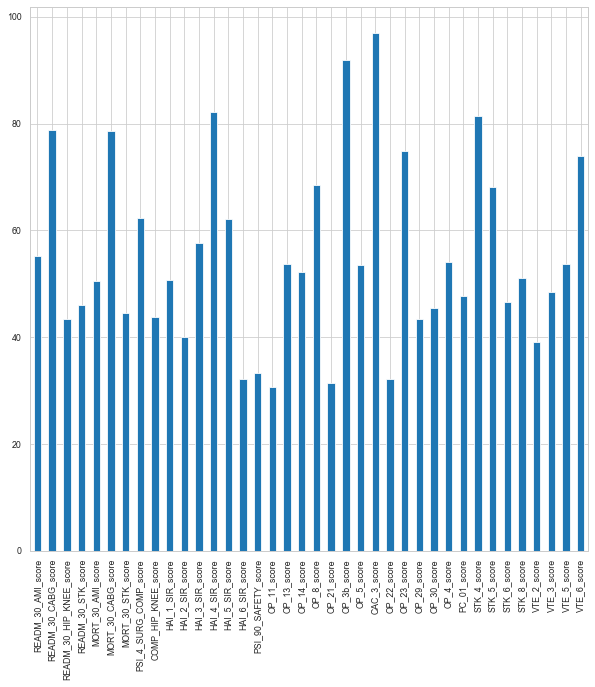

In [170]:

columns_with_missing_data = round(100 * (master_data_x.isnull().sum() / len(master_data_x.index)), 2)
columns_with_missing_data[columns_with_missing_data > 30].plot(kind='bar', figsize=(10,10))
plt.show()

In [27]:
print(np.sum(master_data_x.isnull().sum().to_list()))


131507


In [28]:

## The Score columns are having 131127 NA values, score columns are very important for our further analysis. As these are all independent(X) variables
## we will deal with the NA cleaning after merging with Dependent variable (ratings- y) in later phase

master_data_x.head()



,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,...,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,-0.866907,...,0.538880,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331
1,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,1.574551,...,0.324044,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN
2,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,0.156930,...,0.538880,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,0.078174,...,NaN,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,0.629471,...,NaN,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN


## Load the dependent variable i.e. the `rating` from the  `Hospital Genral Information.csv` file


In [29]:
hospital_ratings = pd.read_csv("Hospital General Information.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"]).set_index('Provider ID')

hospital_ratings.to_csv('cleaned_hospital_ratings_data.csv')

hospital_ratings.head()


,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
Provider ID,,,,,,,,,,,,,,,,,,,,,
10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,...,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,...,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,Yes,...,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...


In [35]:
master_data_y = hospital_ratings.drop(['Hospital Name'], axis=1)


master_data_y.head()

,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
Provider ID,,,,,,,,,,,,,,,,,,,,,
10001,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
10005,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,...,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
10006,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
10007,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,...,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
10008,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,Yes,Y,...,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...


In [36]:
master_data_y.columns

Index(['Address', 'City', 'State', 'ZIP Code', 'County Name', 'Phone Number',
       'Hospital Type', 'Hospital Ownership', 'Emergency Services',
       'Meets criteria for meaningful use of EHRs', 'Hospital overall rating',
       'Hospital overall rating footnote', 'Mortality national comparison',
       'Mortality national comparison footnote',
       'Safety of care national comparison',
       'Safety of care national comparison footnote',
       'Readmission national comparison',
       'Readmission national comparison footnote',
       'Patient experience national comparison',
       'Patient experience national comparison footnote',
       'Effectiveness of care national comparison',
       'Effectiveness of care national comparison footnote',
       'Timeliness of care national comparison',
       'Timeliness of care national comparison footnote',
       'Efficient use of medical imaging national comparison',
       'Efficient use of medical imaging national comparison footnot

In [31]:
hospital_ratings[['Hospital overall rating']].isnull().sum()


Hospital overall rating    1170
dtype: int64

In [37]:
master_data_y = master_data_y.iloc[:,[10]]
master_data_y.head()

,Hospital overall rating
Provider ID,
10001,3.0
10005,3.0
10006,2.0
10007,3.0
10008,3.0


In [38]:
print(master_data_y.columns)

Index(['Hospital overall rating'], dtype='object')


## Merge X (independent) & Y (dependent) variables  using Provider id

In [39]:
master_data = pd.merge(master_data_x, master_data_y, on= "Provider ID")
master_data.head()


,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,...,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score,Hospital overall rating
0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,-0.866907,...,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331,3.0
1,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,1.574551,...,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN,3.0
2,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,0.156930,...,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331,2.0
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,0.078174,...,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN,3.0
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,0.629471,...,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN,3.0


In [40]:
master_data

,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,...,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score,Hospital overall rating
0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,-0.866907,...,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331,3.0
1,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,1.574551,...,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN,3.0
2,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,0.156930,...,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331,2.0
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,0.078174,...,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN,3.0
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,0.629471,...,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN,3.0
5,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,-0.526375,0.314444,...,-4.929290,NaN,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,-3.876657,2.0
6,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,NaN,0.629471,...,NaN,NaN,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,NaN,3.0
7,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,-1.236623,1.653308,...,NaN,0.193305,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,0.416331,3.0
8,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-7.207848,NaN,NaN,NaN,NaN,NaN
9,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,NaN,NaN,-2.363284,...,NaN,-2.207021,-0.915528,-1.392818,0.178342,-0.450362,0.819555,0.635329,NaN,2.0


In [41]:
master_data_without_na = master_data[master_data['Hospital overall rating'].notnull()]
master_data_without_na.head()


,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,...,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score,Hospital overall rating
0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,-0.866907,...,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331,3.0
1,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,1.574551,...,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN,3.0
2,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,0.156930,...,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331,2.0
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,0.078174,...,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN,3.0
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,0.629471,...,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN,3.0


In [42]:
master_data_with_na = master_data[~master_data['Hospital overall rating'].notnull()]
master_data_with_na.head()


,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,...,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score,Hospital overall rating
8,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-7.207848,NaN,NaN,NaN,NaN,NaN
32,BIBB MEDICAL CENTER,208 PIERSON AVE,CENTREVILLE,AL,35042,BIBB,2059264881,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.987898,NaN,NaN,NaN,NaN,NaN
49,HALE COUNTY HOSPITAL,508 GREEN STREET,GREENSBORO,AL,36744,HALE,3346243024,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.910149,NaN,NaN,NaN,NaN,NaN
54,J PAUL JONES HOSPITAL,317 MCWILLIAMS AVENUE,CAMDEN,AL,36726,WILCOX,3346824131,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-5.730610,NaN,NaN,NaN,NaN,NaN
71,HILL HOSPITAL OF SUMTER COUNTY,751 DERBY DRIVE,YORK,AL,36925,SUMTER,2053925263,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-3.475878,NaN,NaN,NaN,NaN,NaN


In [43]:
np.sum(master_data_without_na.isnull().sum().to_list())


65783

In [44]:
columns_with_missing_data = round(100 * (master_data_without_na.isnull().sum() / len(master_data_without_na.index)), 2)


# Remove all columns having more than 50% NA in the dataset .. which are not going to yield any outcome
# which is close to 1824 NA values in any x measure.. will remove the measure
## The following measures having >50% of its data as NA
## READM_30_CABG - 2623 | PSI_4_SURG_COMP - 1831 | HAI_4_SIR - 2804 | HAI_5_SIR - 1860 | OP_3b - 3267 |
## STK_4 - 2762 | STK_5 - 2133 | VTE_6 - 2417

output = columns_with_missing_data[columns_with_missing_data < 50]
output = list(output.to_dict().keys())
output



['Hospital Name',
 'Address',
 'City',
 'State',
 'ZIP Code',
 'County Name',
 'Phone Number',
 'READM_30_AMI_score',
 'READM_30_COPD_score',
 'READM_30_HF_score',
 'READM_30_HIP_KNEE_score',
 'READM_30_HOSP_WIDE_score',
 'READM_30_PN_score',
 'READM_30_STK_score',
 'MORT_30_AMI_score',
 'MORT_30_COPD_score',
 'MORT_30_HF_score',
 'MORT_30_PN_score',
 'MORT_30_STK_score',
 'COMP_HIP_KNEE_score',
 'HAI_1_SIR_score',
 'HAI_2_SIR_score',
 'HAI_3_SIR_score',
 'HAI_6_SIR_score',
 'PSI_90_SAFETY_score',
 'H_CLEAN_LINEAR_SCORE_score',
 'H_COMP_1_LINEAR_SCORE_score',
 'H_COMP_2_LINEAR_SCORE_score',
 'H_COMP_3_LINEAR_SCORE_score',
 'H_COMP_4_LINEAR_SCORE_score',
 'H_COMP_5_LINEAR_SCORE_score',
 'H_COMP_6_LINEAR_SCORE_score',
 'H_COMP_7_LINEAR_SCORE_score',
 'H_HSP_RATING_LINEAR_SCORE_score',
 'H_QUIET_LINEAR_SCORE_score',
 'H_RECMND_LINEAR_SCORE_score',
 'OP_10_score',
 'OP_11_score',
 'OP_13_score',
 'OP_14_score',
 'Provider ID',
 'ED_1b_score',
 'ED_2b_score',
 'OP_18b_score',
 'OP_20_score'

In [45]:
master_data_without_na = master_data_without_na[output]
master_data_without_na.head()

,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.866907,0.370423,...,0.071075,NaN,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,3.0
1,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,1.574551,0.036453,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,3.0
2,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,0.156930,0.904776,...,0.328611,NaN,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,2.0
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,0.078174,0.570805,...,-3.448585,-1.232556,NaN,-3.019716,NaN,0.333841,0.381176,NaN,NaN,3.0
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,0.629471,-0.765075,...,0.714915,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,3.0


In [46]:
master_data_without_na.isnull().sum()


Hospital Name                 0
Address                       0
City                          0
State                         0
ZIP Code                      0
                           ... 
VTE_1_score                 327
VTE_2_score                 780
VTE_3_score                1212
VTE_5_score                1461
Hospital overall rating       0
Length: 61, dtype: int64

In [47]:
# Impute only relevant numerical columns
master_data_without_na.iloc[ : , 8:] =  master_data_without_na.iloc[ : , 8:].apply(lambda x: x.fillna(x.median()), axis=0)

master_data_without_na.head()



,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.866907,0.370423,...,0.071075,0.368028,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,3.0
1,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,1.574551,0.036453,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,3.0
2,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,0.156930,0.904776,...,0.328611,0.368028,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,2.0
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,0.078174,0.570805,...,-3.448585,-1.232556,0.324044,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,3.0
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,0.629471,-0.765075,...,0.714915,0.368028,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,3.0


In [48]:
master_data_without_na = master_data_without_na.drop(master_data_without_na.iloc[:, 1:8],  axis = 1)

master_data_without_na['Hospital overall rating'], factors_hospital_overall_rating =  pd.factorize(master_data_without_na['Hospital overall rating'])

cleaned_master_data = master_data_without_na.drop(['Hospital Name'], axis=1).set_index('Provider ID')

# save the cleaned master data
cleaned_master_data.to_csv("cleaned_master_data.csv")

cleaned_master_data.head()


,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score,MORT_30_AMI_score,MORT_30_COPD_score,MORT_30_HF_score,MORT_30_PN_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
Provider ID,,,,,,,,,,,,,,,,,,,,,
10001,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569,1.249515,-1.094132,-0.165556,0.427705,...,0.071075,0.368028,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0
10005,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118,-1.546065,0.434008,-2.286446,-2.103663,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,0
10006,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980,-2.105181,0.883461,-2.354862,-0.861860,...,0.328611,0.368028,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,1
10007,0.078174,0.570805,0.019388,-1.237171,-0.130886,-0.124569,0.051410,-1.094132,-1.533872,-1.148430,...,-3.448585,-1.232556,0.324044,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,0
10008,0.629471,-0.765075,0.019388,-0.147737,0.774096,0.061873,0.051410,-0.105335,-0.370803,0.332182,...,0.714915,0.368028,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,0


# Exploratory Data Analysis

In [73]:


# General Hospital Ratings
cleaned_hospital_ratings = pd.read_csv("cleaned_hospital_ratings_data.csv", index_col='Provider ID')
all_hospital_ratings = cleaned_hospital_ratings[['Hospital overall rating']]

# Group-1 Readmission
cleaned_readmission = pd.read_csv("cleaned_readmission_data.csv", index_col='Provider ID')
read_master = pd.read_csv("read_master_data.csv", index_col='Provider ID')

# Group-2 Mortality
cleaned_mortality = pd.read_csv("cleaned_mortality_data.csv", index_col='Provider ID')
mort_master = pd.read_csv("mort_master_data.csv", index_col='Provider ID')

# Group-3 Safety
cleaned_safety = pd.read_csv("cleaned_safety_data.csv", index_col='Provider ID')
safe_master = pd.read_csv("safe_master_data.csv", index_col='Provider ID')

# Group-4 Experience
cleaned_experience = pd.read_csv("cleaned_experience_data.csv", index_col='Provider ID')
expe_master = pd.read_csv("expe_master_data.csv", index_col='Provider ID')

# Group-5 Medical
cleaned_medical = pd.read_csv("cleaned_medical_data.csv", index_col='Provider ID')
medi_master = pd.read_csv("medi_master_data.csv", index_col='Provider ID')

# Group-6 Timeliness
cleaned_timeliness = pd.read_csv("cleaned_timeliness_data.csv", index_col='Provider ID')
time_master = pd.read_csv("time_master_data.csv", index_col='Provider ID')

# Group-7 Effectiveness
cleaned_effectiveness = pd.read_csv("cleaned_effectiveness_data.csv", index_col='Provider ID')
effe_master = pd.read_csv("effe_master_data.csv", index_col='Provider ID')

# Cleaned master dataset
cleaned_master = pd.read_csv("cleaned_master_data.csv", index_col='Provider ID')


In [74]:

cleaned_hospital_ratings['Hospital Type'].value_counts()

Acute Care Hospitals         3382
Critical Access Hospitals    1337
Childrens                      99
Name: Hospital Type, dtype: int64

In [51]:
hospital_ratings =  cleaned_hospital_ratings[cleaned_hospital_ratings['Hospital Type'] == 'Acute Care Hospitals']

hospital_ratings['Hospital Type'], factors_hospital_type =  pd.factorize(hospital_ratings['Hospital Type'])

hospital_ratings.head()

,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
Provider ID,,,,,,,,,,,,,,,,,,,,,
10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0,Government - Hospital District or Authority,Yes,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0,Government - Hospital District or Authority,Yes,...,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0,Government - Hospital District or Authority,Yes,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,0,Voluntary non-profit - Private,Yes,...,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,0,Proprietary,Yes,...,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...


In [52]:

hospital_ratings['Hospital overall rating'].value_counts()
hospital_ratings = func_numeric(hospital_ratings,'Hospital overall rating')
hospital_ratings.head()


,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
Provider ID,,,,,,,,,,,,,,,,,,,,,
10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0,Government - Hospital District or Authority,Yes,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0,Government - Hospital District or Authority,Yes,...,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0,Government - Hospital District or Authority,Yes,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,0,Voluntary non-profit - Private,Yes,...,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,0,Proprietary,Yes,...,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...


In [53]:
# Let's check the Ownership type for the hospitals.

hospital_ratings['Hospital Ownership'].value_counts()

# We see the Private hospitals have the data regarding the ratings in the dataset.


Voluntary non-profit - Private                 1383
Proprietary                                     723
Voluntary non-profit - Other                    369
Voluntary non-profit - Church                   284
Government - Hospital District or Authority     281
Government - Local                              183
Physician                                        63
Government - State                               54
Government - Federal                             38
Tribal                                            4
Name: Hospital Ownership, dtype: int64

In [54]:

# Let us remove the NA's values-


hospital_ratings = hospital_ratings[hospital_ratings['Hospital overall rating'].notnull()]
hospital_ratings.head()

,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
Provider ID,,,,,,,,,,,,,,,,,,,,,
10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0,Government - Hospital District or Authority,Yes,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0,Government - Hospital District or Authority,Yes,...,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0,Government - Hospital District or Authority,Yes,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,0,Voluntary non-profit - Private,Yes,...,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,0,Proprietary,Yes,...,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...


## Univariate Analysis - segmented

In [55]:
hospital_ratings.groupby(['State', 'Hospital overall rating']).agg({'State': np.count_nonzero})


State
State Hospital overall rating       
AK    2.0                          1
      3.0                          7
AL    2.0                         15
      3.0                         48
      4.0                         12
...                              ...
WV    3.0                         15
      4.0                          2
WY    2.0                          2
      3.0                          5
      4.0                          3

[205 rows x 1 columns]

In [56]:

hospital_ratings.groupby(['State'])['Hospital overall rating'].agg({'Hospital overall rating': np.mean }).sort_values(by=['Hospital overall rating'], ascending= False).head()

,Hospital overall rating
State,
SD,4.200000
WI,3.692308
DE,3.666667
ID,3.666667
IN,3.587500


In [57]:

hospital_ratings.groupby(['State']).size().sort_values(ascending=False).head()

State
CA    283
TX    263
FL    164
NY    147
PA    142
dtype: int64

In [58]:

avg_by_state = hospital_ratings.groupby(['State'])['Hospital overall rating'].agg({'Hospital overall rating': np.mean })

avg_by_state = avg_by_state.sort_values(by=['Hospital overall rating'], ascending= False).reset_index()


# We see that South Dakota(SD) has the highest average of 4.2 but the frequency is not the highest.
# we see that Indiana has an average of 3.58 and has the highest frequency.
# We see that Wisconsin has an average of 3.69 and a good count of providers.

avg_by_state.head()


,State,Hospital overall rating
0,SD,4.200000
1,WI,3.692308
2,DE,3.666667
3,ID,3.666667
4,IN,3.587500


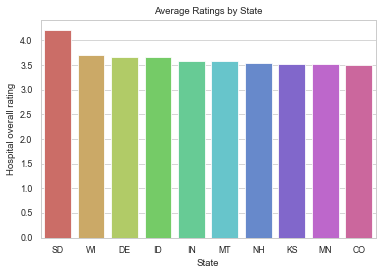

In [59]:
# The above observation can be explored graphically as well
sns.barplot(x= 'State', y= "Hospital overall rating", data = avg_by_state.head(10), palette = 'hls')

plt.title("Average Ratings by State")
plt.show()



### Hospital ownership analysis

In [60]:
# The average rating for hospitals owned by Physicians is the highest
avg_by_hosp_ownership = hospital_ratings.groupby(["Hospital Ownership"])["Hospital overall rating"].agg({"Hospital overall rating": np.mean })

avg_by_hosp_ownership = avg_by_hosp_ownership.sort_values(by=["Hospital overall rating"], ascending= False).reset_index()

avg_by_hosp_ownership.head(10)


,Hospital Ownership,Hospital overall rating
0,Physician,4.096774
1,Voluntary non-profit - Church,3.145455
2,Voluntary non-profit - Other,3.112069
3,Voluntary non-profit - Private,3.066978
4,Government - Hospital District or Authority,2.961686
5,Government - Federal,2.933333
6,Proprietary,2.905213
7,Government - Local,2.791667
8,Government - State,2.636364
9,Tribal,2.500000


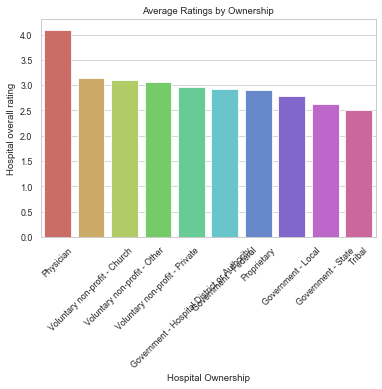

In [61]:

plot = sns.barplot(x = "Hospital Ownership", y= "Hospital overall rating", data = avg_by_hosp_ownership.head(10), palette = 'hls')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.title("Average Ratings by Ownership")
plt.show()



### Readmission analysis

In [62]:

# Here we see that the average ratings of hospitals which have above the national average for readmissions is about 3.57 and around 791 hospitals rank here
# A considerable number of hospitals have average same as national average and their average rating is around 3.03
# Above and Below national average hospitals are similar in number with respect to the readmissions count.


hospital_ratings.groupby(["Readmission national comparison"]).size().sort_values(ascending=False).head()

Readmission national comparison
Same as the National average    1299
Below the National average       847
Above the National average       791
dtype: int64

In [63]:


avg_by_readmission = hospital_ratings.groupby(["Readmission national comparison"])["Hospital overall rating"].agg({"Hospital overall rating": np.mean })

avg_by_readmission = avg_by_readmission.sort_values(by=["Hospital overall rating"], ascending= False).reset_index()

# Those which are below the national average have an average rating around 2.37.
avg_by_readmission.head(10)


,Readmission national comparison,Hospital overall rating
0,Above the National average,3.567636
1,Same as the National average,3.032333
2,Below the National average,2.375443


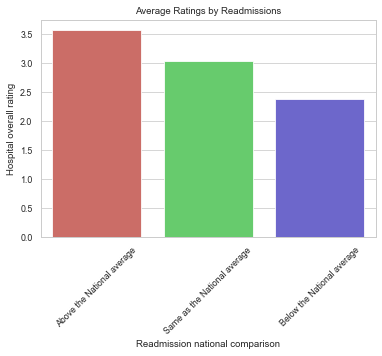

In [64]:

plot = sns.barplot(x = "Readmission national comparison", y= "Hospital overall rating", data = avg_by_readmission.head(10), palette = 'hls')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.title("Average Ratings by Readmissions")
plt.show()

### Plotting utility functions

In [67]:

def plot_avg_comparison(col_name):
    print(hospital_ratings.groupby([col_name]).size().sort_values(ascending=False).head())
    avg_by_col_name = hospital_ratings.groupby([col_name])["Hospital overall rating"].agg({"Hospital overall rating": np.mean })
    avg_by_col_name = avg_by_col_name.sort_values(by=["Hospital overall rating"], ascending= False).reset_index()
    plot = sns.barplot(x = col_name, y= "Hospital overall rating", data = avg_by_col_name.head(10), palette = 'hls')
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    plt.title("Average " +  col_name)
    plt.show()
 


def plot_corr_map(df):
    plt.figure(figsize = (20,10))
    df_corr = df.corr()
    sns.heatmap(df_corr, cmap='coolwarm' )
    plt.show()


### Average Mortality Analysis

Mortality national comparison
Same as the National average    2124
Above the National average       400
Below the National average       343
dtype: int64


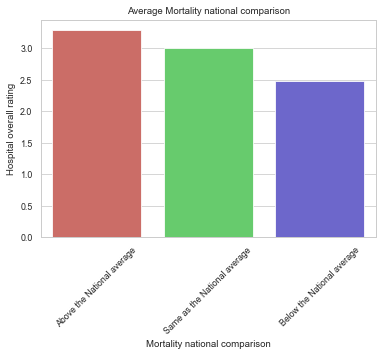

In [68]:

# Excluding the NA's, around 400 hospitals have mortality rate above the national average
# A considerable number of hospitals (2124) have mortality rate same as the National average
# Few hospitals (343) have the mortality rate below the National average.

plot_avg_comparison("Mortality national comparison")


Efficient use of medical imaging national comparison
Same as the National average    1806
Above the National average       359
Below the National average       340
dtype: int64


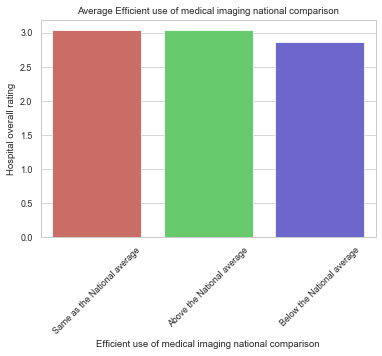

In [69]:
# There's not much difference between the average ratings of above and same as
# national average hospitals by medical group variables
plot_avg_comparison("Efficient use of medical imaging national comparison")

Timeliness of care national comparison
Same as the National average    1185
Below the National average       899
Above the National average       826
dtype: int64


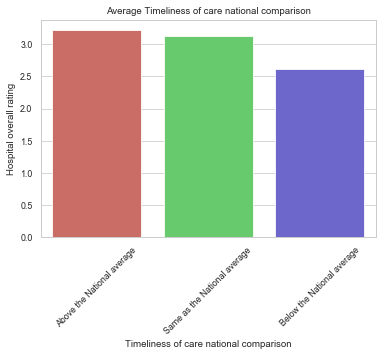

In [70]:

# Timeliness has a significant effect on the average rating (from 2.62 to 3.22)

plot_avg_comparison("Timeliness of care national comparison")

Effectiveness of care national comparison
Same as the National average    1665
Above the National average       991
Below the National average       405
dtype: int64


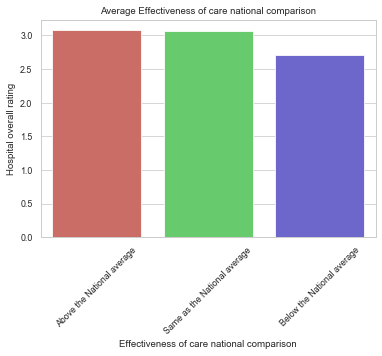

In [71]:

plot_avg_comparison("Effectiveness of care national comparison")

## Bivariate Analysis

#### Using correlation heat maps we can see that there is not much correlation between various measures per group.

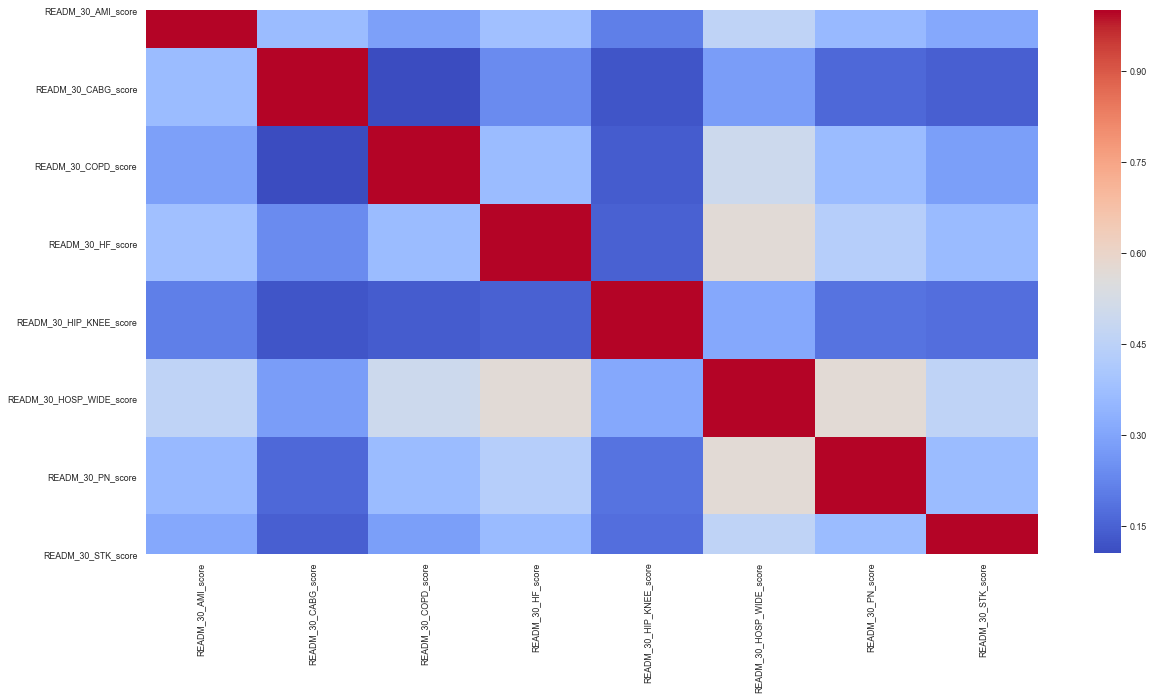

In [75]:
plot_corr_map(cleaned_readmission)

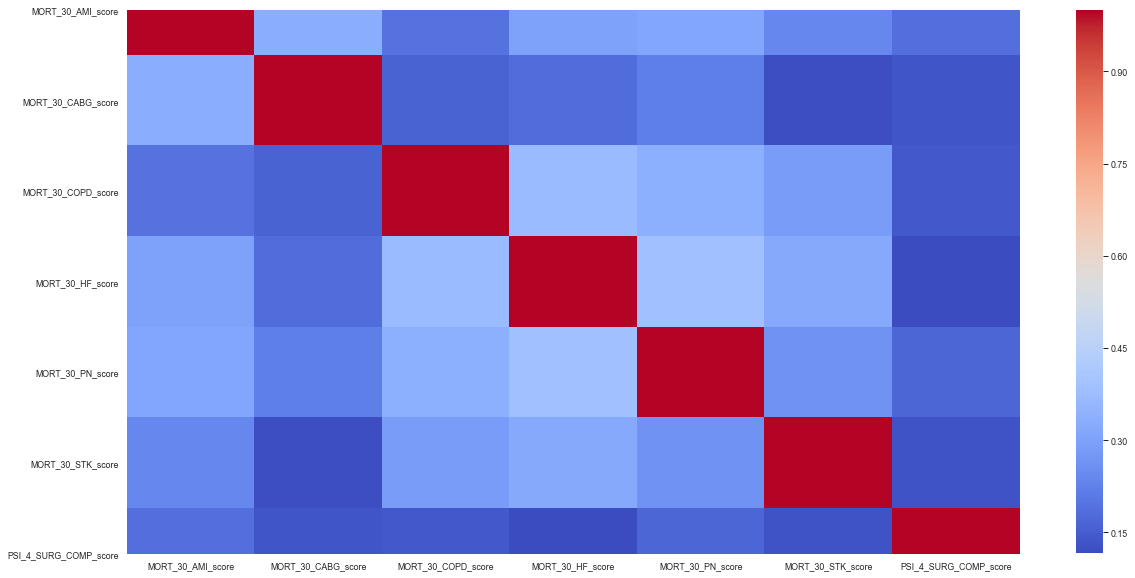

In [76]:
plot_corr_map(cleaned_mortality)


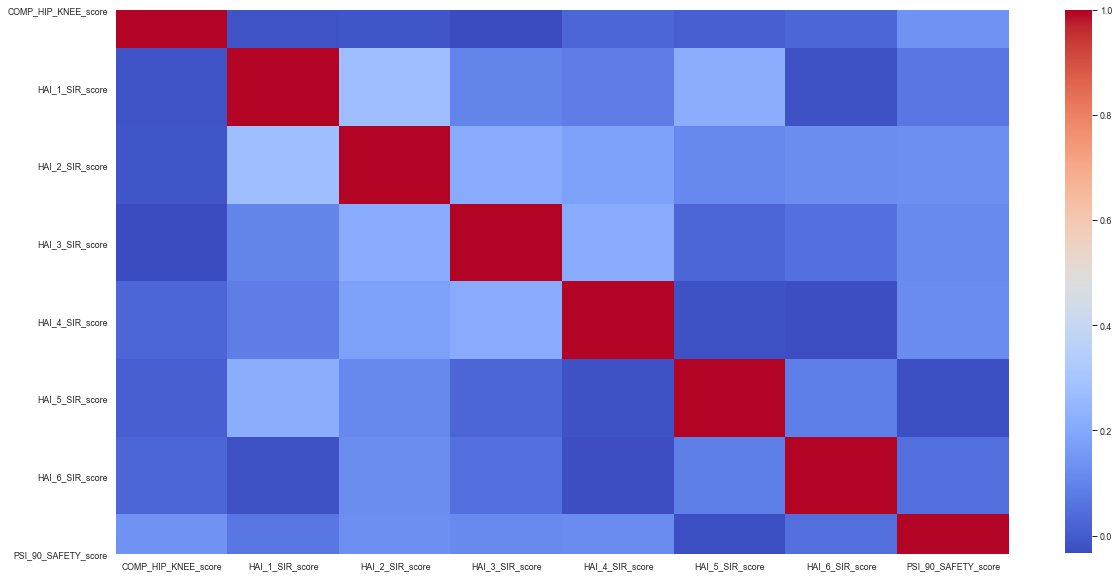

In [77]:
plot_corr_map(cleaned_safety)


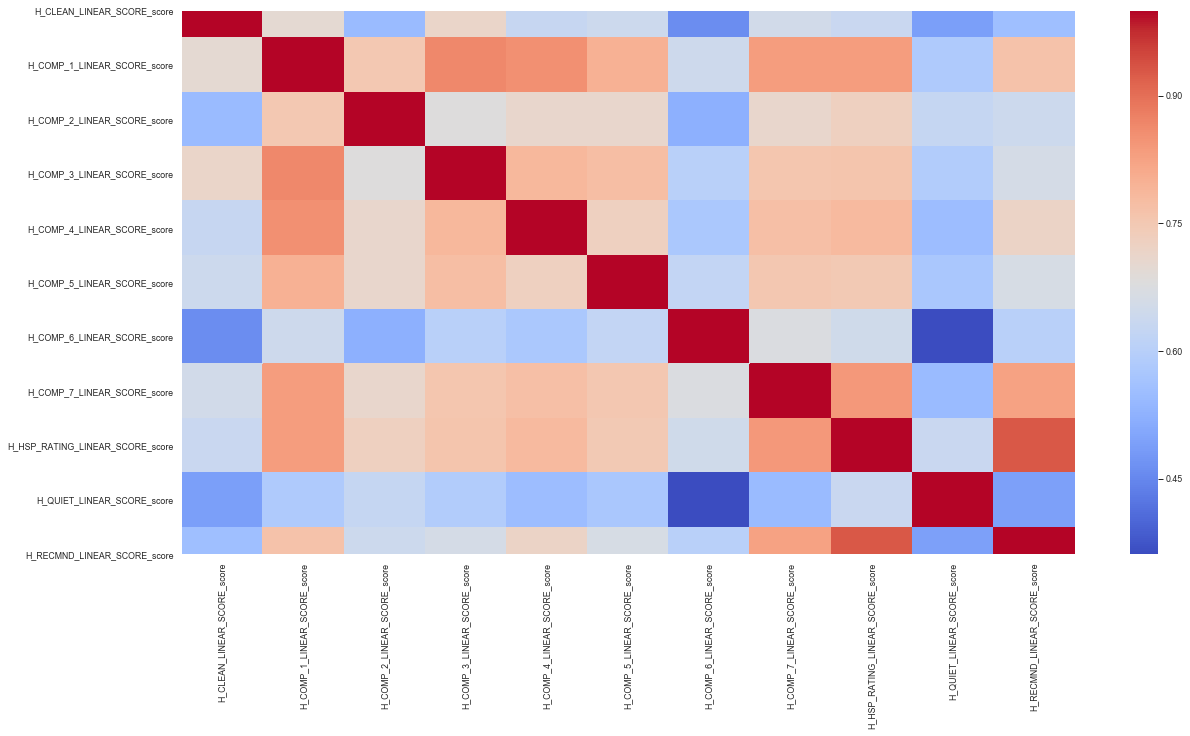

In [78]:
plot_corr_map(cleaned_experience)


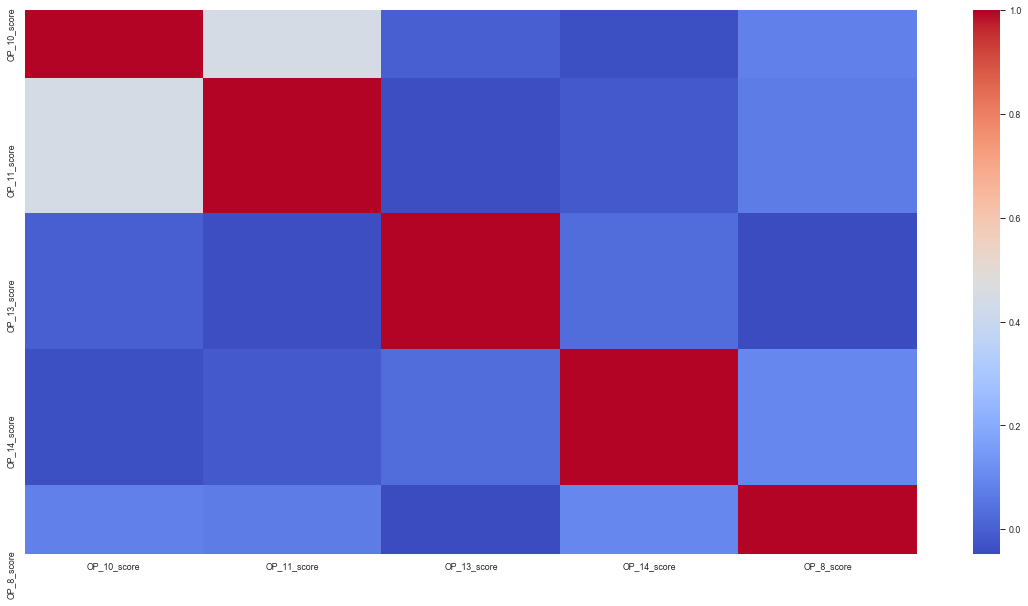

In [79]:
plot_corr_map(cleaned_medical)


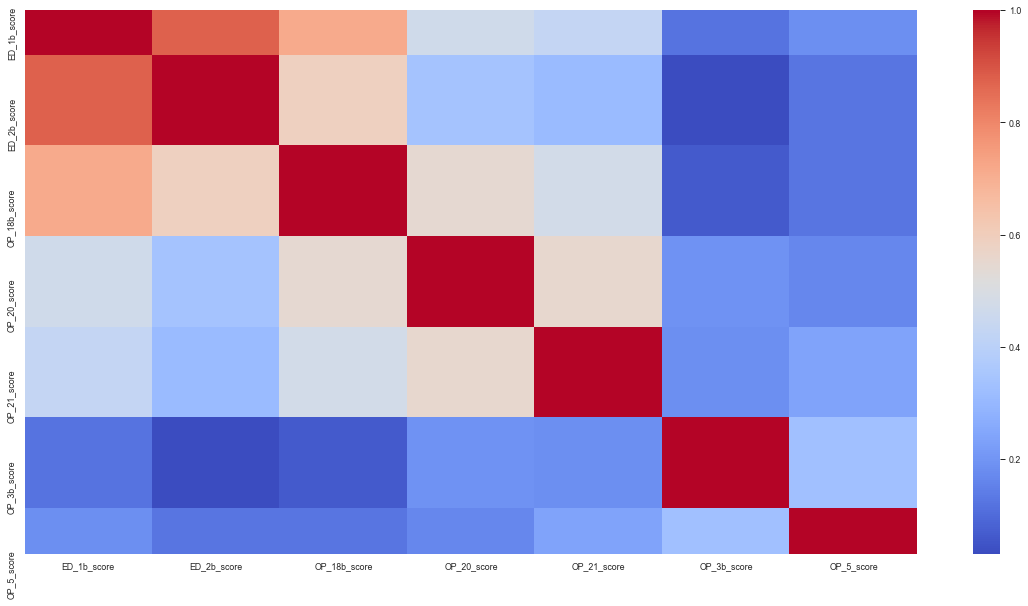

In [80]:
plot_corr_map(cleaned_timeliness)


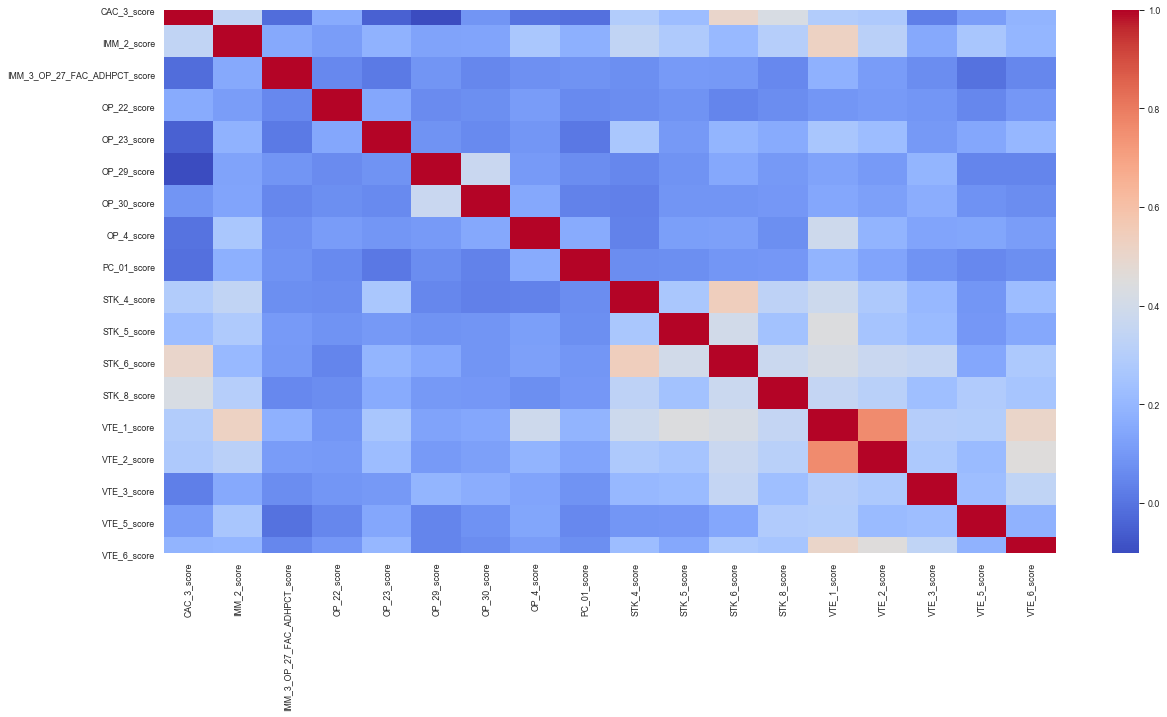

In [81]:
plot_corr_map(cleaned_effectiveness)


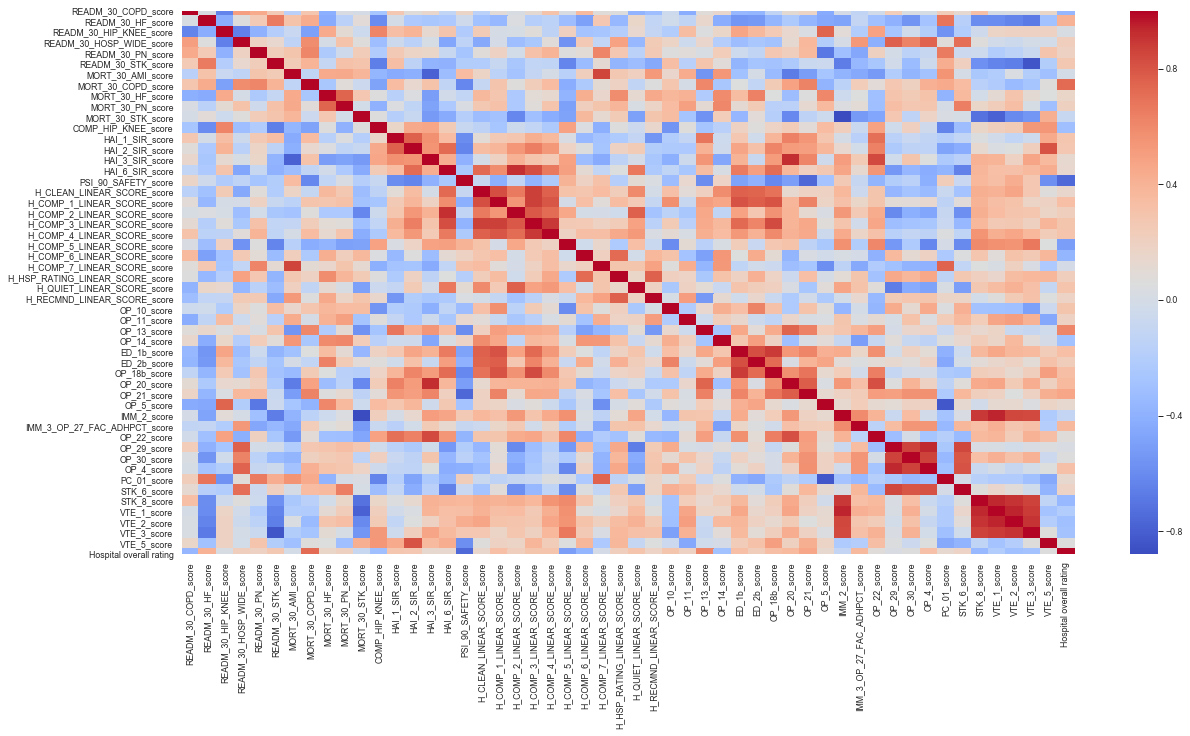

In [82]:
plot_corr_map(cleaned_master.head(10))


## Random Forest Model

In [83]:

# Cleaned master dataset
cleaned_master = pd.read_csv("cleaned_master_data.csv", index_col='Provider ID')


In [85]:

# split into train and test
from sklearn.model_selection import train_test_split

#cleaned_master_data['Hospital overall rating'], factors_hospital_overall_rating =  pd.factorize(cleaned_master_data['Hospital overall rating'])

X = cleaned_master.loc[:, cleaned_master.columns != 'Hospital overall rating']
y = cleaned_master.loc[:, 'Hospital overall rating']

#from sklearn import preprocessing
#y = preprocessing.label_binarize(y, classes=[ 1, 2, 3, 4, 5])


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size=0.7,
                                                    test_size=0.3, random_state=100)



In [86]:
# This is the first RandomForest model in which we specify a few parameters.
# The accuracy comes out to be around 66% - which is good and indicates that the model is not overfitting.

# 100 estimators

from sklearn.ensemble import RandomForestClassifier

model_rf1= RandomForestClassifier(n_estimators= 100,                                   
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

#Train the model using the training sets y_pred=clf.predict(X_test)
model_rf1.fit(X_train, y_train)

y_pred= model_rf1.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


model_rf1_score = cross_val_score(model_rf1, X, y, cv=10)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

print("=== All AUC Scores ===")
print(model_rf1_score)

print_ln()

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", model_rf1_score.mean())
print_ln()


Accuracy: 0.663013698630137
Mean Absolute Error: 0.5506849315068493
Mean Squared Error: 1.0547945205479452
Root Mean Squared Error: 1.027031898505565
=== Confusion Matrix ===
[[500  15  17   0   0]
 [127  78   0   0   0]
 [142   0 148   0   0]
 [  1   0  32   0   0]
 [  3  32   0   0   0]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.65      0.94      0.77       532
           1       0.62      0.38      0.47       205
           2       0.75      0.51      0.61       290
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00        35

    accuracy                           0.66      1095
   macro avg       0.40      0.37      0.37      1095
weighted avg       0.63      0.66      0.62      1095

-------------------------------------------------------------------------------- 

=== All AUC Scores ===
[

In [88]:
# This is the second RandomForest model in which we choose a different criterion
# The accuracy comes out to be around 70% - which is good and indicates that the model is not overfitting.

# 100 estimators


from sklearn.ensemble import RandomForestClassifier

model_rf2= RandomForestClassifier(n_estimators= 100,                                   
                                  random_state = 100,
                                  criterion='entropy',
                                  min_samples_leaf=30,
                                  min_samples_split=30)


#Train the model using the training sets y_pred=clf.predict(X_test)
model_rf2.fit(X_train, y_train)

y_pred= model_rf2.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


model_rf2_score = cross_val_score(model_rf2, X, y, cv=10)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

print("=== All AUC Scores ===")
print(model_rf2_score)

print_ln()

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", model_rf2_score.mean())
print_ln()


Accuracy: 0.7004566210045662
Mean Absolute Error: 0.491324200913242
Mean Squared Error: 0.9442922374429223
Root Mean Squared Error: 0.9717470027959553
=== Confusion Matrix ===
[[496  15  21   0   0]
 [108  97   0   0   0]
 [116   0 174   0   0]
 [  1   0  32   0   0]
 [  1  34   0   0   0]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       532
           1       0.66      0.47      0.55       205
           2       0.77      0.60      0.67       290
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00        35

    accuracy                           0.70      1095
   macro avg       0.42      0.40      0.40      1095
weighted avg       0.66      0.70      0.67      1095

-------------------------------------------------------------------------------- 

=== All AUC Scores ===


In [89]:
# In this third RandomForest model, we're simply using the default settings and increasing the number of estimators.
# The accuracy comes out to be around 78%

# 1500 estimators

from sklearn.ensemble import RandomForestClassifier

model_rf3= RandomForestClassifier(n_estimators= 1500)

#Train the model using the training sets y_pred=clf.predict(X_test)
model_rf3.fit(X_train, y_train)

y_pred= model_rf3.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


model_rf3_score = cross_val_score(model_rf3, X, y, cv=10)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

print("=== All AUC Scores ===")
print(model_rf3_score)

print_ln()

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", model_rf3_score.mean())
print_ln()


Accuracy: 0.7844748858447489
Mean Absolute Error: 0.3515981735159817
Mean Squared Error: 0.6712328767123288
Root Mean Squared Error: 0.819288030372914
=== Confusion Matrix ===
[[503  12  17   0   0]
 [ 77 128   0   0   0]
 [ 80   0 210   0   0]
 [  0   0  24   9   0]
 [  0  26   0   0   9]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       532
           1       0.77      0.62      0.69       205
           2       0.84      0.72      0.78       290
           3       1.00      0.27      0.43        33
           4       1.00      0.26      0.41        35

    accuracy                           0.78      1095
   macro avg       0.87      0.56      0.63      1095
weighted avg       0.80      0.78      0.77      1095

-------------------------------------------------------------------------------- 

=== All AUC Scores ===


In [90]:
# Feature importance

import pandas as pd
feature_importances = pd.DataFrame(model_rf3.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
READM_30_HOSP_WIDE_score,0.090838
PSI_90_SAFETY_score,0.073052
H_HSP_RATING_LINEAR_SCORE_score,0.041548
H_RECMND_LINEAR_SCORE_score,0.037807
MORT_30_PN_score,0.037458
H_COMP_1_LINEAR_SCORE_score,0.032385
H_COMP_7_LINEAR_SCORE_score,0.031960
MORT_30_HF_score,0.029905
H_COMP_3_LINEAR_SCORE_score,0.027499
READM_30_PN_score,0.026573


### Importance of various features, deduced by ELI5 library

In [91]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model_rf1, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
0.0691 ± 0.0095,x3
0.0301 ± 0.0070,x25
0.0247 ± 0.0064,x16
0.0210 ± 0.0058,x18
0.0161 ± 0.0064,x24
0.0160 ± 0.0040,x20
0.0156 ± 0.0045,x21
0.0107 ± 0.0040,x27
0.0094 ± 0.0037,x23
0.0088 ± 0.0039,x9


## PCA and Unsupervised Clustering Model

In [92]:
effe_master.columns
print_ln()

eff = effe_master.drop(effe_master.iloc[:, 0:7], axis=1)
eff.columns

-------------------------------------------------------------------------------- 



Index(['CAC_3_score', 'IMM_2_score', 'IMM_3_OP_27_FAC_ADHPCT_score',
       'OP_22_score', 'OP_23_score', 'OP_29_score', 'OP_30_score',
       'OP_4_score', 'PC_01_score', 'STK_4_score', 'STK_5_score',
       'STK_6_score', 'STK_8_score', 'VTE_1_score', 'VTE_2_score',
       'VTE_3_score', 'VTE_5_score', 'VTE_6_score'],
      dtype='object')

In [93]:
eff = eff.dropna(thresh= 3)

eff.to_csv("eff_group_data.csv")

eff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3739 entries, 10001 to 670106
Data columns (total 18 columns):
CAC_3_score                     126 non-null float64
IMM_2_score                     3641 non-null float64
IMM_3_OP_27_FAC_ADHPCT_score    3633 non-null float64
OP_22_score                     3243 non-null float64
OP_23_score                     1209 non-null float64
OP_29_score                     2731 non-null float64
OP_30_score                     2626 non-null float64
OP_4_score                      2080 non-null float64
PC_01_score                     2509 non-null float64
STK_4_score                     899 non-null float64
STK_5_score                     1540 non-null float64
STK_6_score                     2577 non-null float64
STK_8_score                     2361 non-null float64
VTE_1_score                     3551 non-null float64
VTE_2_score                     2926 non-null float64
VTE_3_score                     2482 non-null float64
VTE_5_score              

In [94]:
eff = eff.apply(lambda x: x.fillna(x.median()), axis=0)
eff

,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
Provider ID,,,,,,,,,,,,,,,,,,
10001,0.214905,0.363857,-0.233117,-1.201473,0.179361,0.367430,0.071075,0.368028,0.538880,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331
10005,0.214905,0.530272,-0.099026,-0.108314,0.783472,0.692171,0.500302,0.545870,0.324044,0.318473,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,0.416331
10006,0.214905,0.613480,0.169157,0.438265,0.179361,-0.101641,0.328611,0.368028,0.538880,0.318473,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331
10007,0.214905,0.530272,-2.110397,0.438265,0.179361,-2.627406,-3.448585,-1.232556,0.324044,0.318473,0.411517,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,0.416331
10008,0.214905,0.197442,-2.780853,0.438265,0.179361,0.836500,0.714915,0.368028,0.324044,0.318473,0.411517,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,0.416331
10011,0.214905,-0.801048,-2.110397,-0.654894,-3.545988,0.150936,-1.688755,0.368028,0.538880,-4.929290,0.411517,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,-3.876657
10012,0.214905,0.613480,0.370294,-0.108314,0.280046,0.980830,0.843683,0.723713,-2.253994,0.318473,0.411517,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,0.416331
10016,0.214905,0.447065,-0.568346,-0.108314,0.179361,0.547841,0.843683,0.368028,0.109207,0.318473,0.193305,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,0.416331
10018,0.214905,-4.462180,-1.305848,0.984844,0.179361,0.367430,0.414456,0.368028,0.324044,0.318473,0.411517,0.322230,0.344086,-7.207848,0.381176,0.331873,0.457530,0.416331


In [95]:
## With Incremental PCA

from sklearn.decomposition import IncrementalPCA, PCA
pca = IncrementalPCA()
eff_pca = pca.fit_transform(eff)
eff_pca = pd.DataFrame(eff_pca, columns=eff.columns)
eff_pca.index = eff.index
eff_pca


,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
Provider ID,,,,,,,,,,,,,,,,,,
10001,-0.180572,-0.607867,0.232818,-0.803696,-1.135688,-0.417882,0.405073,0.610692,-0.023666,0.094456,-0.056203,-0.382423,-0.178485,-0.295547,-0.951391,0.427680,0.986205,0.043967
10005,0.401928,0.447193,0.248439,-0.609422,0.168175,1.237431,-0.021647,0.393217,0.402495,0.114624,0.112884,0.652379,0.017990,0.709158,-0.050015,0.231321,-0.037481,0.017220
10006,-0.251522,-0.789182,0.631346,-0.555298,0.568469,-0.032184,-0.973734,0.355299,-0.030700,-0.647529,0.354895,-0.500252,0.443655,0.319710,0.162679,-0.283218,0.333688,0.003018
10007,-2.137142,-2.654506,-3.416023,-0.054714,2.107179,1.477375,0.817468,0.189865,0.058911,1.500646,-1.514176,1.126527,0.279476,0.217848,0.272794,0.728082,-0.322195,-0.024118
10008,0.292337,1.365921,-1.585151,-2.154003,0.311725,-0.424090,-0.016704,0.124668,0.084082,0.162811,-0.000749,-0.050615,0.223894,-0.058710,0.041347,-0.023225,0.023259,-0.010291
10011,-7.346154,-1.643492,1.666418,-2.322151,0.682709,-0.433134,-1.886539,1.993465,1.991890,-0.436584,1.534259,-3.547446,0.938734,-4.799636,-3.036992,2.465804,-0.337203,0.169791
10012,0.894629,0.319966,0.611553,-0.537562,-0.495990,0.630663,-0.063223,-2.123720,0.664617,0.262883,0.923817,0.449549,-0.334612,-0.040027,0.129645,0.115956,0.036467,-0.012850
10016,0.862069,0.700704,-0.299850,-0.712329,-0.345928,0.195920,0.147987,-0.032019,0.182507,-0.215953,-0.158343,0.221248,-0.032695,0.002959,-0.072643,-0.118570,0.024445,0.007596
10018,-5.077776,5.563602,-0.535745,2.837922,0.575312,-1.104549,-0.010870,0.742790,-0.895718,0.134565,0.663483,0.172213,-2.662754,-0.276647,0.522760,0.496817,-0.074199,0.067516


In [168]:
pca.explained_variance_ratio_


array([0.16346639, 0.10704536, 0.08895391, 0.07967539, 0.07136638,
       0.06168113, 0.05517529, 0.0515865 , 0.04968937, 0.04710474,
       0.04481184, 0.03988629, 0.03555335, 0.0322619 , 0.02610687,
       0.02154447, 0.02027522, 0.00381559])

In [97]:
eff_pca_weights = pd.DataFrame(pca.components_, columns=eff.columns)
eff_pca_weights

,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
0,0.013112,0.407054,0.254310,0.186861,0.067392,0.200449,0.186468,0.149609,0.109179,0.071309,0.111184,0.283824,0.240842,0.493763,0.350765,0.247209,0.169015,0.090697
1,-0.004115,-0.382797,-0.262350,0.176968,0.038425,0.428204,0.455362,-0.051015,0.021705,0.020547,0.026775,0.143951,0.168603,-0.395197,0.028418,0.318909,0.210064,0.070253
2,-0.018033,-0.009293,0.647264,0.023588,-0.042580,0.437171,0.342969,0.042725,-0.017079,-0.063245,-0.083932,-0.222000,-0.268611,-0.045030,-0.187193,-0.151376,-0.262763,-0.076785
3,0.001057,-0.333627,0.647207,0.128411,0.001756,-0.296159,-0.314917,-0.133874,0.012670,0.022469,0.037996,0.245041,0.188510,-0.283089,0.063694,0.210104,0.139948,0.053870
4,-0.004422,0.054654,-0.068666,0.893894,0.035746,-0.127695,-0.077942,0.055277,0.094972,0.008578,-0.043437,-0.342309,-0.135674,-0.006189,-0.067306,-0.053983,0.094934,0.058826
5,-0.001122,0.267776,0.131484,-0.259661,-0.026408,-0.103097,0.128966,-0.106737,-0.022749,0.030288,-0.094649,-0.515557,0.160003,-0.065693,-0.247379,0.173721,0.630273,0.097479
6,-0.030664,-0.428617,0.013629,-0.149264,0.021344,-0.138207,0.062163,0.187924,-0.021030,-0.034676,-0.133300,-0.325702,-0.422802,0.256721,0.510088,0.292867,0.064978,0.117474
7,-0.010402,-0.012318,-0.020444,-0.129297,-0.048711,0.104904,-0.189373,0.266743,0.905326,-0.035466,-0.051174,-0.021443,-0.035481,-0.084948,-0.128231,0.111711,-0.012444,-0.026601
8,-0.013118,0.124171,-0.050847,0.020218,-0.001396,0.249918,-0.391724,0.210931,-0.304498,-0.011297,0.011921,0.135616,-0.329499,0.043877,-0.395567,0.583667,0.004105,-0.044523
9,-0.001217,-0.074190,-0.016856,-0.015560,0.049420,0.609732,-0.564202,-0.246609,-0.045094,-0.002115,-0.070071,-0.223414,0.150039,0.029113,0.299901,-0.217952,0.145550,0.041992


In [98]:
# The weights of various measures in the effectiveness group
eff_measure_weight = eff_pca.mean(axis=1)
eff_measure_weight


Provider ID
10001    -0.124029
10005     0.246438
10006    -0.049492
10007    -0.074817
10008    -0.094083
            ...   
670096   -0.027870
670097   -0.206249
670098   -0.019406
670103    0.107001
670106    0.049805
Length: 3739, dtype: float64

In [99]:

eff_scores = pd.DataFrame({'effe' : eff_measure_weight})
eff_scores

,effe
Provider ID,
10001,-0.124029
10005,0.246438
10006,-0.049492
10007,-0.074817
10008,-0.094083
10011,-0.797015
10012,0.079542
10016,0.019839
10018,0.063262


### Utility function

In [100]:
def function_group_score(numeric_df, score_name):
    df = numeric_df.dropna(thresh= 3)
    imputed_df = df.apply(lambda x: x.fillna(x.median()), axis=0)
    pca = IncrementalPCA()
    df_pca = pca.fit_transform(imputed_df)
    df_pca = pd.DataFrame(df_pca, columns= df.columns)
    df_pca.index = df.index
    df_with_weight = df_pca.mean(axis=1)
    df_scores = pd.DataFrame({score_name : df_with_weight})
    return df_scores



In [101]:

df = pd.read_csv("effe_master_data.csv", index_col='Provider ID')
num_df = df.drop(effe_master.iloc[:, 0:7], axis=1)
num_df.to_csv('effectiveness_scores.csv')
num_df.head(10)
print_ln()

effectiveness_scores = function_group_score(eff, 'effe_score')
effectiveness_scores.head(10)

-------------------------------------------------------------------------------- 



,effe_score
Provider ID,
10001,-0.124029
10005,0.246438
10006,-0.049492
10007,-0.074817
10008,-0.094083
10011,-0.797015
10012,0.079542
10016,0.019839
10018,0.063262


In [102]:

df = pd.read_csv("read_master_data.csv", index_col= 'Provider ID')
df.columns
print_ln()

num_df = df.drop(df.iloc[:, 0:7], axis=1)
num_df.to_csv('readmission_scores.csv')
num_df.columns
print_ln()

readmission_scores = function_group_score(num_df, 'radm_score')
readmission_scores

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



,radm_score
Provider ID,
10001,-0.309709
10005,0.547881
10006,-0.168701
10007,-0.285020
10008,0.288875
10011,-0.190088
10012,0.298608
10016,0.248827
10019,-0.564132


In [103]:
df = pd.read_csv("mort_master_data.csv", index_col= 'Provider ID')
df.columns
print_ln()

num_df = df.drop(df.iloc[:, 0:7], axis=1)
num_df.to_csv('mortality_scores.csv')
num_df.columns
print_ln()

mortality_scores = function_group_score(num_df, 'mort_score')
mortality_scores

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



,mort_score
Provider ID,
10001,-0.627662
10005,-0.246331
10006,-0.553802
10007,-0.515251
10008,-0.088360
10011,0.051718
10012,0.098717
10016,-0.420800
10019,0.090211


In [104]:

df = pd.read_csv("safe_master_data.csv", index_col='Provider ID')
df.columns
print_ln()

num_df = df.drop(df.iloc[:, 0:7], axis=1)
num_df.to_csv('safety_scores.csv')
num_df.columns
print_ln()

safety_scores = function_group_score(num_df, 'safety_score')
safety_scores

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



,safety_score
Provider ID,
10001,-0.120902
10005,0.202535
10006,-0.419724
10007,0.288169
10011,-0.121613
10012,0.323677
10016,0.109561
10019,0.697717
10021,-0.166125


In [105]:

df = pd.read_csv("expe_master_data.csv", index_col='Provider ID')
df.columns
print_ln()

num_df = df.drop(df.iloc[:, 0:7], axis=1)
num_df.to_csv('experience_scores.csv')
num_df.columns
print_ln()

experience_scores = function_group_score(num_df, 'expe_score')
experience_scores

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



,expe_score
Provider ID,
10001,-0.227843
10005,-0.031616
10006,0.124587
10007,0.334282
10011,-0.235509
10012,0.048671
10016,-0.282386
10019,-0.144424
10021,0.016514


In [106]:
df = pd.read_csv("medi_master_data.csv", index_col='Provider ID')
df.columns
print_ln()

num_df = df.drop(df.iloc[:, 0:7], axis=1)
num_df.columns
num_df.to_csv('medical_scores.csv')
print_ln()

medical_scores = function_group_score(num_df, 'medi_score')
medical_scores

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



,medi_score
Provider ID,
10001,-0.049667
10005,-0.378802
10006,-0.060915
10011,0.260861
10012,0.260007
10016,-0.721338
10019,-0.500481
10021,0.029103
10023,-0.090594


In [107]:
df = pd.read_csv("time_master_data.csv", index_col='Provider ID')
df.columns
print_ln()

num_df = df.drop(df.iloc[:, 0:8], axis=1)
num_df.columns
num_df.to_csv('timeliness_scores.csv')
print_ln()

timeliness_scores = function_group_score(num_df, 'time_score')
timeliness_scores

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



,time_score
Provider ID,
10001,-0.626658
10005,-0.144562
10006,-0.046349
10007,-0.362673
10008,0.233617
10011,-0.235684
10012,0.250186
10016,-0.421927
10018,0.167167


In [108]:
merge1= pd.merge(readmission_scores, mortality_scores, on= 'Provider ID')
merge2= pd.merge(merge1, safety_scores, on= 'Provider ID')
merge3= pd.merge(merge2, experience_scores, on= 'Provider ID')
merge4= pd.merge(merge3, medical_scores, on= 'Provider ID')
merge5= pd.merge(merge4, timeliness_scores, on= 'Provider ID')
merge6= pd.merge(merge5, effectiveness_scores, on= 'Provider ID')
group_scores = merge6

group_scores.columns
print_ln()


group_scores.to_csv("group_score_data.csv")

group_scores


-------------------------------------------------------------------------------- 



,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score
Provider ID,,,,,,,
10001,-0.309709,-0.627662,-0.120902,-0.227843,-0.049667,-0.626658,-0.124029
10005,0.547881,-0.246331,0.202535,-0.031616,-0.378802,-0.144562,0.246438
10006,-0.168701,-0.553802,-0.419724,0.124587,-0.060915,-0.046349,-0.049492
10011,-0.190088,0.051718,-0.121613,-0.235509,0.260861,-0.235684,-0.797015
10012,0.298608,0.098717,0.323677,0.048671,0.260007,0.250186,0.079542
10016,0.248827,-0.420800,0.109561,-0.282386,-0.721338,-0.421927,0.019839
10019,-0.564132,0.090211,0.697717,-0.144424,-0.500481,0.164844,-0.047200
10021,0.161845,-0.219291,-0.166125,0.016514,0.029103,0.314042,0.105945
10023,-0.047022,-0.813730,0.427825,-0.247941,-0.090594,-0.114894,-0.158429


In [109]:
# readmission = 0.22, mortality = 0.22, safety = 0.22, experience = 0.22, medical = 0.04, timeliness = 0.04, effectiveness = 0.04
cms_weights = pd.Series([0.22,  0.22,  0.22,  0.22,  0.04,  0.04,  0.04], index=group_scores.columns)
cms_weights

radm_score      0.22
mort_score      0.22
safety_score    0.22
expe_score      0.22
medi_score      0.04
time_score      0.04
effe_score      0.04
dtype: float64

In [110]:
# Multiply each group_scores with corresponding measure weights given by CMS and sum
# them to form final_score=sum(each_column * cms_weights)/7

final_scores = pd.DataFrame(group_scores.multiply(cms_weights, axis=1).apply(np.sum, axis=1)/7, columns=['final_score'])
final_scores.to_csv('final_scores_data.csv')
final_scores.head(10)

,final_score
Provider ID,
10001,-0.044994
10005,0.013267
10006,-0.032879
10011,-0.019983
10012,0.027560
10016,-0.017256
10019,0.000307
10021,-0.003941
10023,-0.023478


In [111]:
# Save the merged dataset 
all_scores = pd.merge(group_scores, final_scores, on= 'Provider ID')
all_scores.to_csv('all_scores_data.csv')
all_scores.head(10)

,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score,final_score
Provider ID,,,,,,,,
10001,-0.309709,-0.627662,-0.120902,-0.227843,-0.049667,-0.626658,-0.124029,-0.044994
10005,0.547881,-0.246331,0.202535,-0.031616,-0.378802,-0.144562,0.246438,0.013267
10006,-0.168701,-0.553802,-0.419724,0.124587,-0.060915,-0.046349,-0.049492,-0.032879
10011,-0.190088,0.051718,-0.121613,-0.235509,0.260861,-0.235684,-0.797015,-0.019983
10012,0.298608,0.098717,0.323677,0.048671,0.260007,0.250186,0.079542,0.027560
10016,0.248827,-0.420800,0.109561,-0.282386,-0.721338,-0.421927,0.019839,-0.017256
10019,-0.564132,0.090211,0.697717,-0.144424,-0.500481,0.164844,-0.047200,0.000307
10021,0.161845,-0.219291,-0.166125,0.016514,0.029103,0.314042,0.105945,-0.003941
10023,-0.047022,-0.813730,0.427825,-0.247941,-0.090594,-0.114894,-0.158429,-0.023478


### ~ Calculation of final scores is now complete ~

# Hierarchal Clustering

### Utility function

In [121]:

def predicted_ratings(df):

    star_ratings_by_frequency= df['Hospital overall rating'].value_counts().index.to_list()
    cluster_id_by_frequency= df['ClusterID'].value_counts().index.to_list()

    def cluster_to_rating(x):
        return star_ratings_by_frequency[cluster_id_by_frequency.index(x)]


    return df['ClusterID'].apply(lambda x: cluster_to_rating(x))


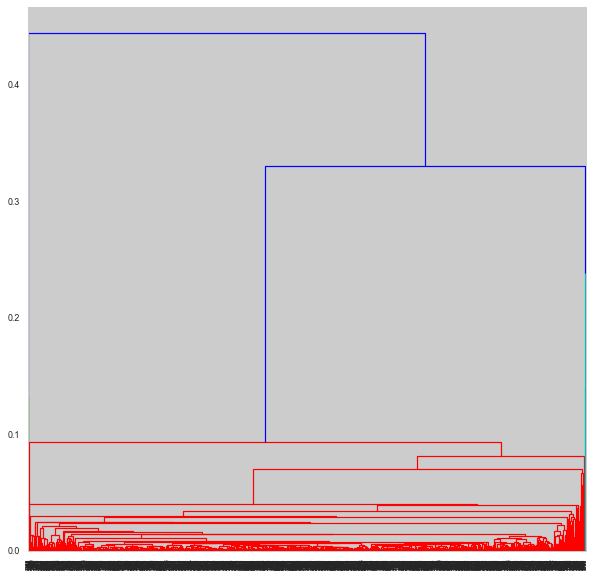

In [132]:

final_scores_scaled = pd.DataFrame(StandardScaler().fit_transform(final_scores), index=final_scores.index, columns=['final_score'])

plt.figure(figsize = (10,10))

# single linkage
mergings = linkage(final_scores_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()


### Let's cut the height of the dendrogram at 5 groups

In [131]:

cluster_labels = cut_tree(mergings, n_clusters=5).reshape(-1, )

# Adjust ClusterID to reflect the star rating system
final_scores_scaled['ClusterID'] = cluster_labels

final_scores_scaled.head(10)

# Merge the group_scores and ratings dataset

final_scores_scaled_and_ratings= pd.merge(final_scores_scaled, cleaned_hospital_ratings[['Hospital overall rating']], on="Provider ID")
final_scores_scaled_and_ratings.head()

print_ln()

real_ratings =  final_scores_scaled_and_ratings['Hospital overall rating']
final_score_pred_ratings= predicted_ratings(final_scores_scaled_and_ratings)


print("Accuracy:", metrics.accuracy_score(real_ratings, final_score_pred_ratings))


-------------------------------------------------------------------------------- 

Accuracy: 0.41801577418015773


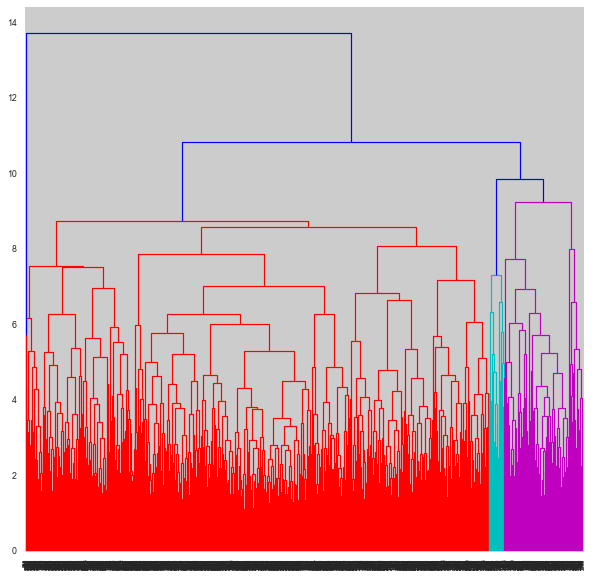

In [129]:
# Using group scores
group_scores_scaled = pd.DataFrame(StandardScaler().fit_transform(group_scores), index=group_scores.index, columns=group_scores.columns)

# complete linkage
plt.figure(figsize = (10,10))

mergings = linkage(group_scores_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [133]:

cluster_labels = cut_tree(mergings, n_clusters=5).reshape(-1, )

# Adjust ClusterID to reflect the star rating system
group_scores_scaled['ClusterID'] = cluster_labels 

group_scores_scaled.head(10)

# Merge the group_scores and ratings dataset

group_scores_scaled_and_ratings= pd.merge(group_scores_scaled, cleaned_hospital_ratings[['Hospital overall rating']], on="Provider ID")
group_scores_scaled_and_ratings.head()

print_ln()

real_ratings =  group_scores_scaled_and_ratings['Hospital overall rating']
group_score_pred_ratings= predicted_ratings(group_scores_scaled_and_ratings)


print("Accuracy:", metrics.accuracy_score(real_ratings, group_score_pred_ratings))


-------------------------------------------------------------------------------- 

Accuracy: 0.45703611457036114


In [134]:
# Save the dataset with ratings
all_scores_with_cluster =  pd.merge(all_scores, cleaned_hospital_ratings[['Hospital overall rating']], on="Provider ID")
all_scores_with_cluster['ClusterID'] = cluster_labels
all_scores_with_cluster['PredRating'] = pred_ratings
all_scores_with_cluster.to_csv('all_scores_with_clusters_data.csv')
all_scores_with_cluster

,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score,final_score,Hospital overall rating,ClusterID,PredRating
Provider ID,,,,,,,,,,,
10001,-0.309709,-0.627662,-0.120902,-0.227843,-0.049667,-0.626658,-0.124029,-0.044994,3.0,0,3.0
10005,0.547881,-0.246331,0.202535,-0.031616,-0.378802,-0.144562,0.246438,0.013267,3.0,0,3.0
10006,-0.168701,-0.553802,-0.419724,0.124587,-0.060915,-0.046349,-0.049492,-0.032879,2.0,0,3.0
10011,-0.190088,0.051718,-0.121613,-0.235509,0.260861,-0.235684,-0.797015,-0.019983,2.0,0,4.0
10012,0.298608,0.098717,0.323677,0.048671,0.260007,0.250186,0.079542,0.027560,3.0,0,3.0
10016,0.248827,-0.420800,0.109561,-0.282386,-0.721338,-0.421927,0.019839,-0.017256,3.0,0,3.0
10019,-0.564132,0.090211,0.697717,-0.144424,-0.500481,0.164844,-0.047200,0.000307,2.0,0,3.0
10021,0.161845,-0.219291,-0.166125,0.016514,0.029103,0.314042,0.105945,-0.003941,4.0,0,3.0
10023,-0.047022,-0.813730,0.427825,-0.247941,-0.090594,-0.114894,-0.158429,-0.023478,3.0,0,3.0


# Evanston Hospital recommendation

In [138]:
readmission_scores = pd.read_csv("readmission_scores.csv", index_col='Provider ID')
mortality_scores = pd.read_csv("mortality_scores.csv", index_col='Provider ID')
safety_scores = pd.read_csv("safety_scores.csv", index_col='Provider ID')
experience_scores = pd.read_csv("experience_scores.csv", index_col='Provider ID')
medical_scores = pd.read_csv("medical_scores.csv", index_col='Provider ID')
timeliness_scores = pd.read_csv("timeliness_scores.csv", index_col='Provider ID')
effectiveness_scores = pd.read_csv("effectiveness_scores.csv", index_col='Provider ID')


# Hospital group and final scores along with actual and predicted rating
all_scores_with_clusters=  pd.read_csv('all_scores_with_clusters_data.csv', index_col='Provider ID')


In [140]:
all_scores_with_clusters.head()


,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score,final_score,Hospital overall rating,ClusterID,PredRating
Provider ID,,,,,,,,,,,
10001,-0.309709,-0.627662,-0.120902,-0.227843,-0.049667,-0.626658,-0.124029,-0.044994,3.0,0,3.0
10005,0.547881,-0.246331,0.202535,-0.031616,-0.378802,-0.144562,0.246438,0.013267,3.0,0,3.0
10006,-0.168701,-0.553802,-0.419724,0.124587,-0.060915,-0.046349,-0.049492,-0.032879,2.0,0,3.0
10011,-0.190088,0.051718,-0.121613,-0.235509,0.260861,-0.235684,-0.797015,-0.019983,2.0,0,4.0
10012,0.298608,0.098717,0.323677,0.048671,0.260007,0.250186,0.079542,0.027560,3.0,0,3.0


In [141]:
all_scores_with_clusters.describe()

,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score,final_score,Hospital overall rating,ClusterID,PredRating
count,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000
mean,-0.010481,0.007667,-0.015911,-0.068180,0.001410,-0.022293,-0.018184,-0.002955,2.995434,0.004981,3.040681
std,0.342221,0.357493,0.302877,0.237310,0.364820,0.311829,0.174767,0.020427,0.860964,0.115170,0.498342
min,-1.369772,-1.435383,-1.395986,-1.778490,-2.039966,-1.742014,-1.152560,-0.081068,1.000000,0.000000,1.000000
25%,-0.214563,-0.215511,-0.192213,-0.213558,-0.184027,-0.203594,-0.114443,-0.015719,2.000000,0.000000,3.000000
50%,0.005828,0.015576,0.007436,-0.061304,0.058134,0.006894,0.009095,-0.001722,3.000000,0.000000,3.000000
75%,0.224049,0.251592,0.188542,0.087182,0.245363,0.190433,0.101340,0.011177,4.000000,0.000000,3.000000
max,1.212461,1.248527,1.000335,1.012989,0.973467,0.891820,0.634960,0.065085,5.000000,4.000000,5.000000


In [143]:
# Provider: Evanston Hospital Provider.ID = 140010
# Check the group scores for the provider.ID = 140010

evanston_scores= pd.DataFrame(all_scores_with_clusters.loc[140010, :]).transpose().drop(['Hospital overall rating', 'ClusterID', 'PredRating'], axis=1)
evanston_scores.index= ['evanston_scores']
evanston_scores


,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score,final_score
evanston_scores,-0.178459,0.669369,-0.146455,-0.183121,0.09761,-0.071148,-0.267155,0.003695


In [144]:
mean_scores = pd.DataFrame(all_scores_with_clusters.mean(), columns=['mean_scores']).transpose().drop(['Hospital overall rating', 'ClusterID', 'PredRating'], axis=1)
mean_scores

,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score,final_score
mean_scores,-0.010481,0.007667,-0.015911,-0.06818,0.00141,-0.022293,-0.018184,-0.002955


In [145]:
median_scores = pd.DataFrame(all_scores_with_clusters.median(), columns=['median_scores']).transpose().drop(['Hospital overall rating', 'ClusterID', 'PredRating'], axis=1)
median_scores


,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score,final_score
median_scores,0.005828,0.015576,0.007436,-0.061304,0.058134,0.006894,0.009095,-0.001722


In [146]:
five_star_mean_scores= all_scores_with_clusters.drop(['ClusterID', 'PredRating'], axis=1).groupby(['Hospital overall rating']).mean().tail(1)
five_star_mean_scores.index= ['five_star_rating']
five_star_mean_scores

,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score,final_score
five_star_rating,0.316206,0.122956,0.125929,0.1148,0.067468,0.065493,0.059314,0.022467


In [147]:
comparative_analysis= pd.concat([mean_scores, evanston_scores, five_star_mean_scores])
comparative_analysis.info()
comparative_analysis


<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, mean_scores to five_star_rating
Data columns (total 8 columns):
radm_score      3 non-null float64
mort_score      3 non-null float64
safety_score    3 non-null float64
expe_score      3 non-null float64
medi_score      3 non-null float64
time_score      3 non-null float64
effe_score      3 non-null float64
final_score     3 non-null float64
dtypes: float64(8)
memory usage: 216.0+ bytes


,radm_score,mort_score,safety_score,expe_score,medi_score,time_score,effe_score,final_score
mean_scores,-0.010481,0.007667,-0.015911,-0.068180,0.001410,-0.022293,-0.018184,-0.002955
evanston_scores,-0.178459,0.669369,-0.146455,-0.183121,0.097610,-0.071148,-0.267155,0.003695
five_star_rating,0.316206,0.122956,0.125929,0.114800,0.067468,0.065493,0.059314,0.022467


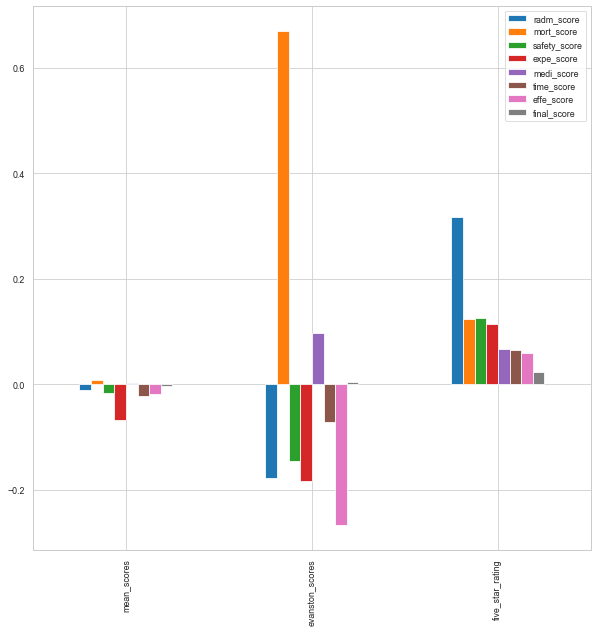

In [169]:
# The means scores are negative for almost all groups
# For 5 star rated hospitals however, the ratings are all positive.

# Evanston hospital, in order to have better ratings, needs to improve in
# - readmission
# - safety
# - experience
# - effectiveness 
# - time score

comparative_analysis.plot(kind='bar', figsize=(10,10))


In [151]:
effectiveness_scores_and_ratings = pd.merge(effectiveness_scores, all_hospital_ratings, on='Provider ID')
effectiveness_scores_and_ratings.head(10)

,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score,Hospital overall rating
Provider ID,,,,,,,,,,,,,,,,,,,
10001,NaN,0.363857,-0.233117,-1.201473,NaN,NaN,0.071075,NaN,0.538880,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331,3.0
10005,NaN,0.530272,-0.099026,-0.108314,0.783472,0.692171,0.500302,0.545870,0.324044,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN,3.0
10006,NaN,0.613480,0.169157,0.438265,NaN,-0.101641,0.328611,NaN,0.538880,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331,2.0
10007,NaN,0.530272,-2.110397,0.438265,NaN,-2.627406,-3.448585,-1.232556,NaN,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN,3.0
10008,NaN,0.197442,-2.780853,0.438265,NaN,0.836500,0.714915,NaN,NaN,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN,3.0
10011,NaN,-0.801048,-2.110397,-0.654894,-3.545988,0.150936,-1.688755,NaN,0.538880,-4.929290,NaN,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,-3.876657,2.0
10012,NaN,0.613480,0.370294,-0.108314,0.280046,0.980830,0.843683,0.723713,-2.253994,NaN,NaN,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,NaN,3.0
10016,NaN,0.447065,-0.568346,-0.108314,NaN,0.547841,0.843683,NaN,0.109207,NaN,0.193305,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,0.416331,3.0
10018,NaN,-4.462180,-1.305848,0.984844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.207848,NaN,NaN,NaN,NaN,NaN


In [152]:
evanston_effectiveness_scores=  pd.DataFrame(effectiveness_scores_and_ratings.loc[140010, :]).transpose().drop(['Hospital overall rating'], axis=1)
evanston_effectiveness_scores.index= ['evanston_scores']
evanston_effectiveness_scores

,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
evanston_scores,NaN,0.363857,-2.445625,0.438265,NaN,0.439594,0.586147,NaN,0.53888,0.539431,0.193305,0.569781,0.069838,0.41159,0.547483,0.697634,0.01303,-1.014665


In [153]:
effectiveness_five_star_mean_scores= effectiveness_scores_and_ratings.groupby(['Hospital overall rating']).mean().tail(1)
effectiveness_five_star_mean_scores.index= ['five_star_rating']
effectiveness_five_star_mean_scores

,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
five_star_rating,0.398105,0.311384,0.226538,0.400828,-0.035335,0.289251,0.233568,0.218869,0.11747,0.106721,0.186693,0.277414,0.090153,0.36326,0.282903,0.230973,0.259214,0.254199


## Utility function

In [154]:

def create_comparative_scores(scores_df):
    score_with_ratings_df= pd.merge(scores_df, all_hospital_ratings, on='Provider ID')
    
    evanston_scores=  pd.DataFrame(score_with_ratings_df.loc[140010, :]).transpose().drop(['Hospital overall rating'], axis=1)
    evanston_scores.index= ['evanston_scores']
    
    five_star_mean_scores= score_with_ratings_df.groupby(['Hospital overall rating']).mean().tail(1)
    five_star_mean_scores.index= ['five_star_rating']
    
    comparative_analysis= pd.concat([evanston_scores, five_star_mean_scores])
    
    return comparative_analysis




In [155]:

effectiveness_comparative_scores= create_comparative_scores(effectiveness_scores)
effectiveness_comparative_scores

,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
evanston_scores,NaN,0.363857,-2.445625,0.438265,NaN,0.439594,0.586147,NaN,0.53888,0.539431,0.193305,0.569781,0.069838,0.41159,0.547483,0.697634,0.013030,-1.014665
five_star_rating,0.398105,0.311384,0.226538,0.400828,-0.035335,0.289251,0.233568,0.218869,0.11747,0.106721,0.186693,0.277414,0.090153,0.36326,0.282903,0.230973,0.259214,0.254199


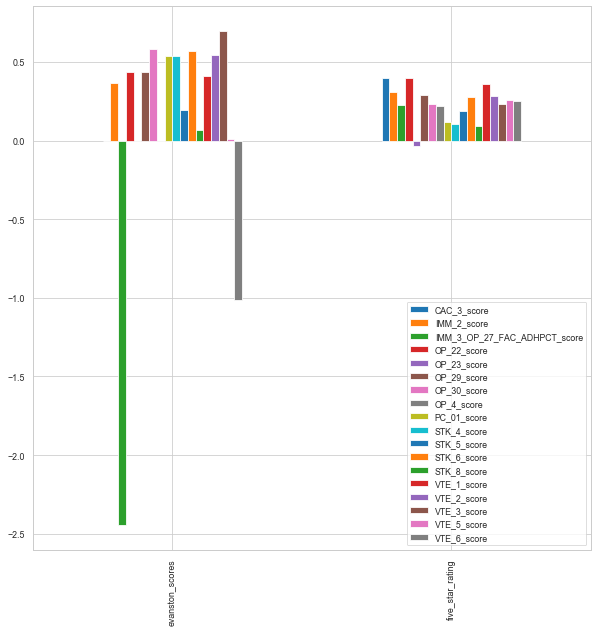

In [159]:
# Within effectiveness group, it's necessary to focus on 
# - IMM_3_OP_27_FAC_ADHPCT_score
# - VTE_6_score

effectiveness_comparative_scores.plot(kind='bar', figsize=(10,10))


In [161]:
timeliness_comparative_scores= create_comparative_scores(timeliness_scores)
timeliness_comparative_scores


,ED_1b_score,ED_2b_score,OP_18b_score,OP_20_score,OP_21_score,OP_3b_score,OP_5_score
evanston_scores,0.322141,0.386960,-0.551243,-1.418142,-0.493019,NaN,NaN
five_star_rating,0.301307,0.174067,-0.045441,0.124765,0.262865,0.447571,0.341165


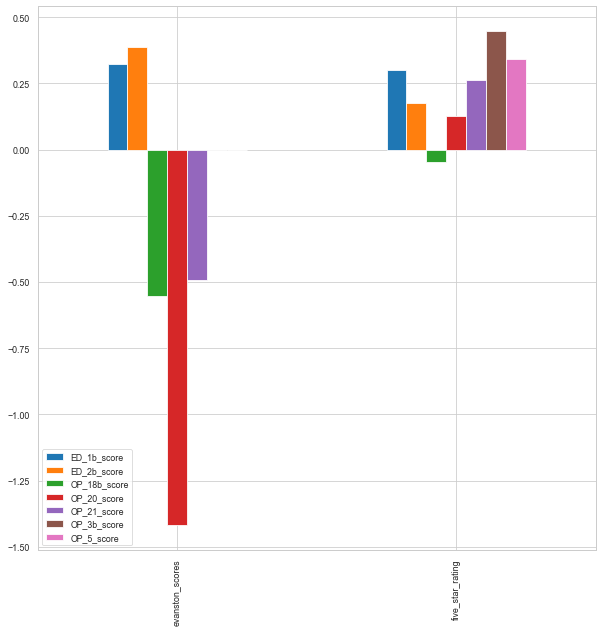

In [163]:
# In this group, Evanston hospital needs to improve 
# - OP_20_score
# - OP_21_score
# - OP_5_score

timeliness_comparative_scores.plot(kind='bar', figsize=(10,10))

In [166]:

mortality_comparative_scores= create_comparative_scores(mortality_scores)
mortality_comparative_scores



,MORT_30_AMI_score,MORT_30_CABG_score,MORT_30_COPD_score,MORT_30_HF_score,MORT_30_PN_score,MORT_30_STK_score,PSI_4_SURG_COMP_score
evanston_scores,2.287874,1.297948,2.141930,1.818503,1.621747,1.460980,2.820911
five_star_rating,0.808731,0.394333,0.596667,0.753027,0.899533,0.395191,0.404256


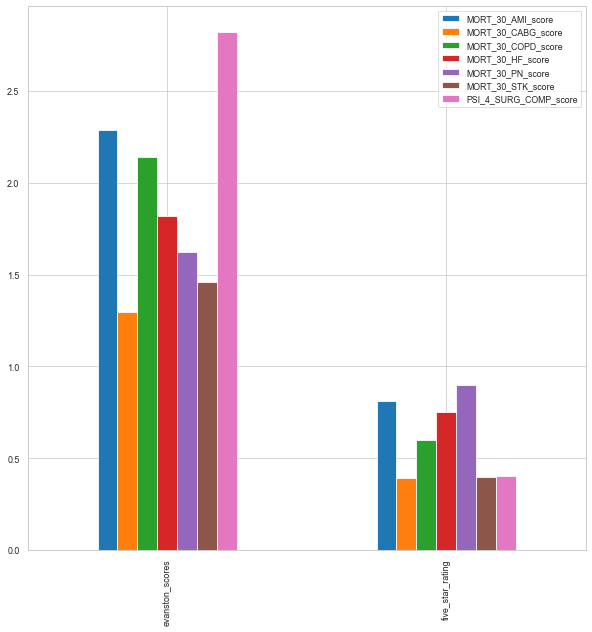

In [165]:

mortality_comparative_scores.plot(kind='bar', figsize=(10,10))